## Семинар 7: "Методы оптимизации"

ФИО:Белозёров Михаил Сергеевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
%matplotlib inline

/Users/mikhailbelozerov/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
def gd (df, shape, point=None, iterations=1000, lr=0.05):
    if point is None:
        point = np.zeros(shape)
    points = np.array([point])
    for i in range(iterations):
        grad = df (point)
        point = point - lr * grad
        points = np.append (points, [point], axis=0)
    return point, points, 'gd'

In [3]:
def momentum (df, shape, point=None, iterations=1000, lr=0.1, gamma=0.9):
    if point is None:
        point = np.zeros(shape)
    points = np.array([point])
    v = np.zeros(shape)
    for i in range(iterations):
        grad = df (point)
        v = gamma * v + grad * lr
        point = point - v
        points = np.append (points, [point], axis=0)
    return point, points, 'momentum'

In [4]:
def nag (df, shape, point=None, iterations=1000, lr=0.01, gamma=0.9):
    if point is None:
        point = np.zeros(shape)
    points = np.array([point])
    v = np.zeros(shape)
    for i in range(iterations):
        grad = df (point - gamma * v)
        v = gamma * v + grad * lr
        point = point - v
        points = np.append (points, [point], axis=0)
    return point, points, 'nag'

In [5]:
def Adagrad (df, shape, point=None, iterations=1000, lr=0.3, e=1e-8):
    if point is None:
        point = np.zeros(shape)
    points = np.array([point])
    G = np.zeros(shape)
    for i in range(iterations):
        grad = df (point)
        G += grad ** 2
        point = point - lr / np.sqrt (G + e) * grad
        points = np.append (points, [point], axis=0)
    return point, points, 'Adagrad'

In [6]:
def Adadelta (df, shape, point=None, iterations=100, lr=0.1, e=1e-8, gamma=0.9):
    if point is None:
        point = np.zeros(shape)
    points = np.array([point])
    G = df (point) ** 2
    for i in range(iterations):
        grad = df (point)
        RMS_ = np.sqrt (G + e)
        G = G * gamma + (1 - gamma) * grad ** 2
        RMS = np.sqrt (G)
        point = point - lr * RMS/ RMS_ * grad
        points = np.append (points, [point], axis=0)
    return point, points, 'Adadelta'

In [7]:
def Adam (df, shape, point=None, iterations=1000, lr=0.3, e=1e-8, betta1=0.9, betta2=0.999):
    if point is None:
        point = np.zeros(shape)
    points = np.array([point])
    m = np.zeros (point.shape)
    v = np.zeros (point.shape)
    betta_1_pow = betta1
    betta_2_pow = betta2
    for i in range(iterations):
        grad = df (point)
        m = betta1 * m + (1 - betta1) * grad
        v = betta2 * v + (1 - betta2) * grad ** 2
        betta_1_pow *= betta1
        betta_2_pow *= betta2
        
        point = point - lr / (np.sqrt (v / (1 - betta_2_pow)) + e) * m / (1 - betta_1_pow) * grad
        points = np.append (points, [point], axis=0)
    return point, points, 'Adam'

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [8]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)

In [9]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])
z = X ** 2 + Y ** 2

In [10]:
def plot (grads, point, label, min_point, start_point, z):
    err = (min_point[0] - point[0])**2 + (min_point[1] - point[1])**2
    print label, ': error: ', err
    plt.figure (figsize=(20,20))
    plt.contour (x,y,z)
    minima, = plt.plot (min_point[0],min_point[1], 'o', label='min')
    start, = plt.plot (start_point[0],start_point[1], 'o', label='start')
    line, = plt.plot (grads[:,0],grads[:,1],label=label)
    point, = plt.plot (point[0], point[1], 'o', label=label + ' point')
    plt.legend ([minima, start, line, point])
    plt.show ()

In [11]:
methods = [gd, momentum, nag, Adagrad, Adadelta, Adam]

In [12]:
def draw (methods, z, start):
    for m in methods:
        point, grads, label = m (df, (2), start)
        plot (grads, point, label, (0,0), start, z)

gd : error:  1.5275269563e-91


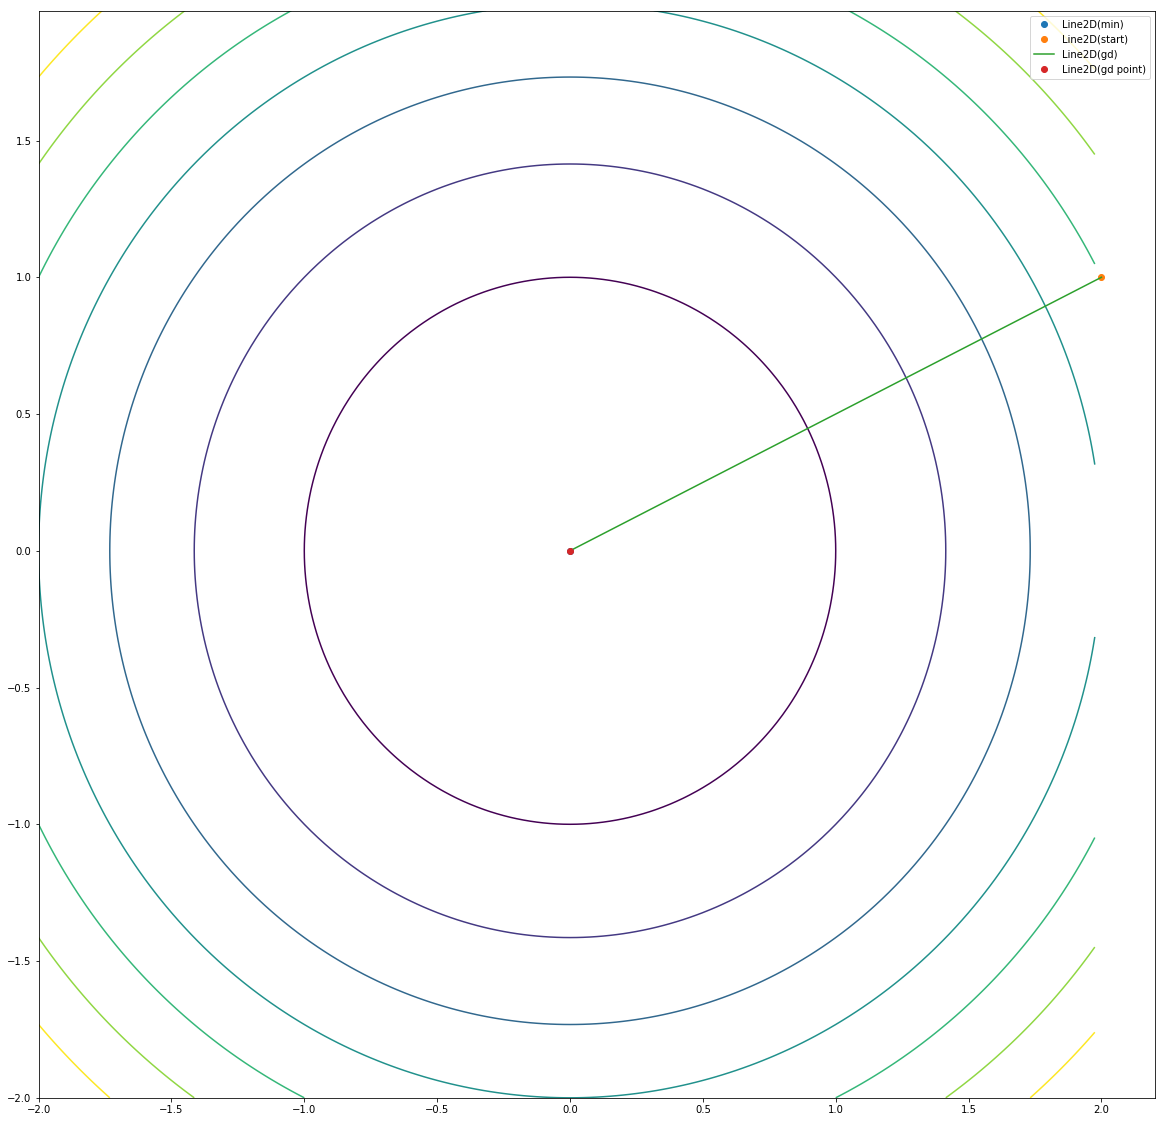

momentum : error:  1.49408582466e-48


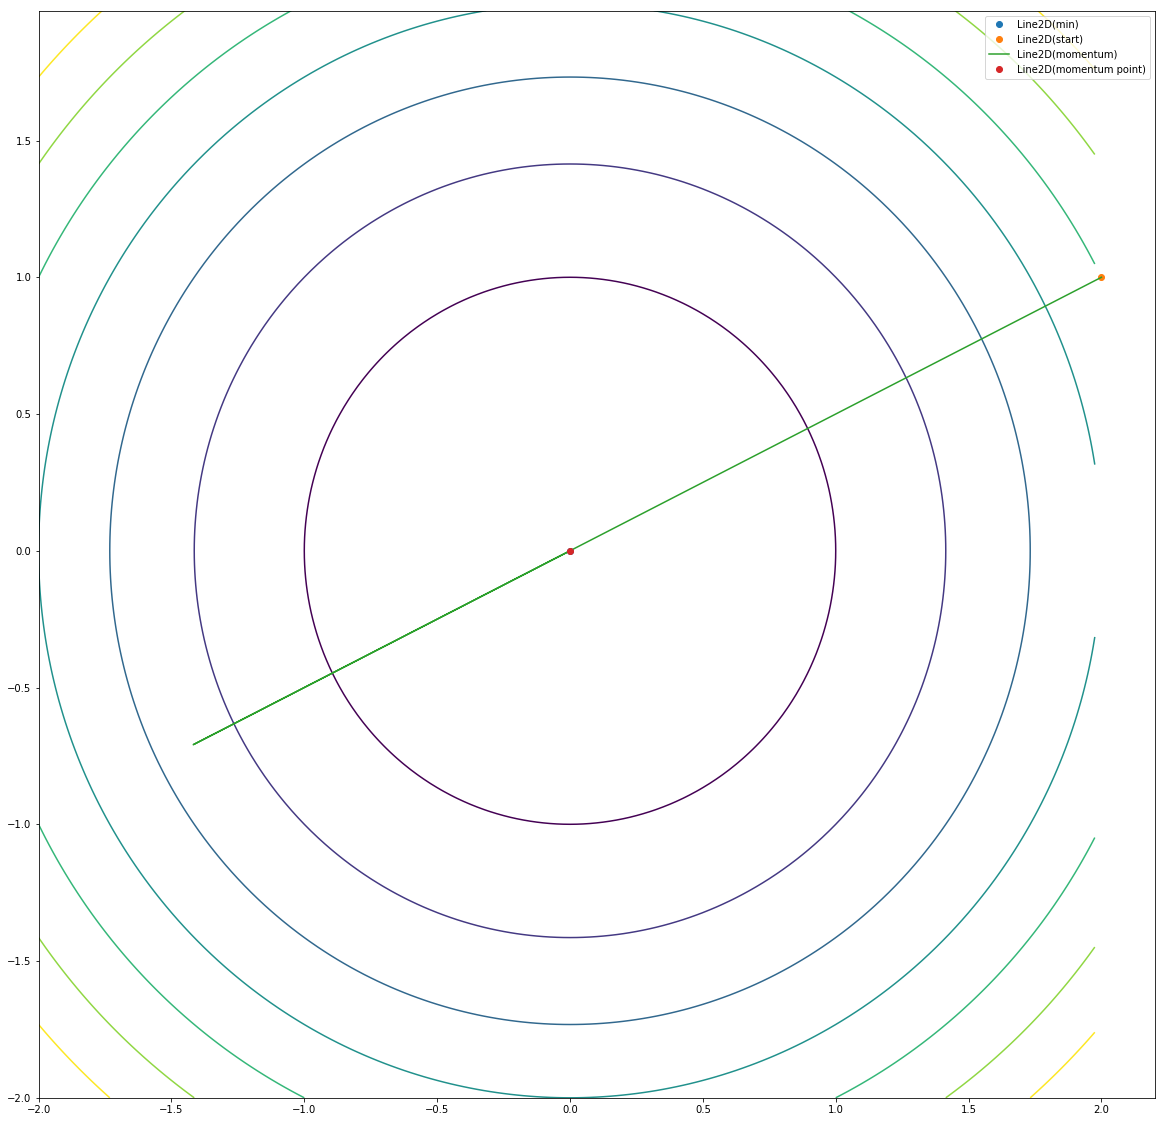

nag : error:  1.31363975262e-54


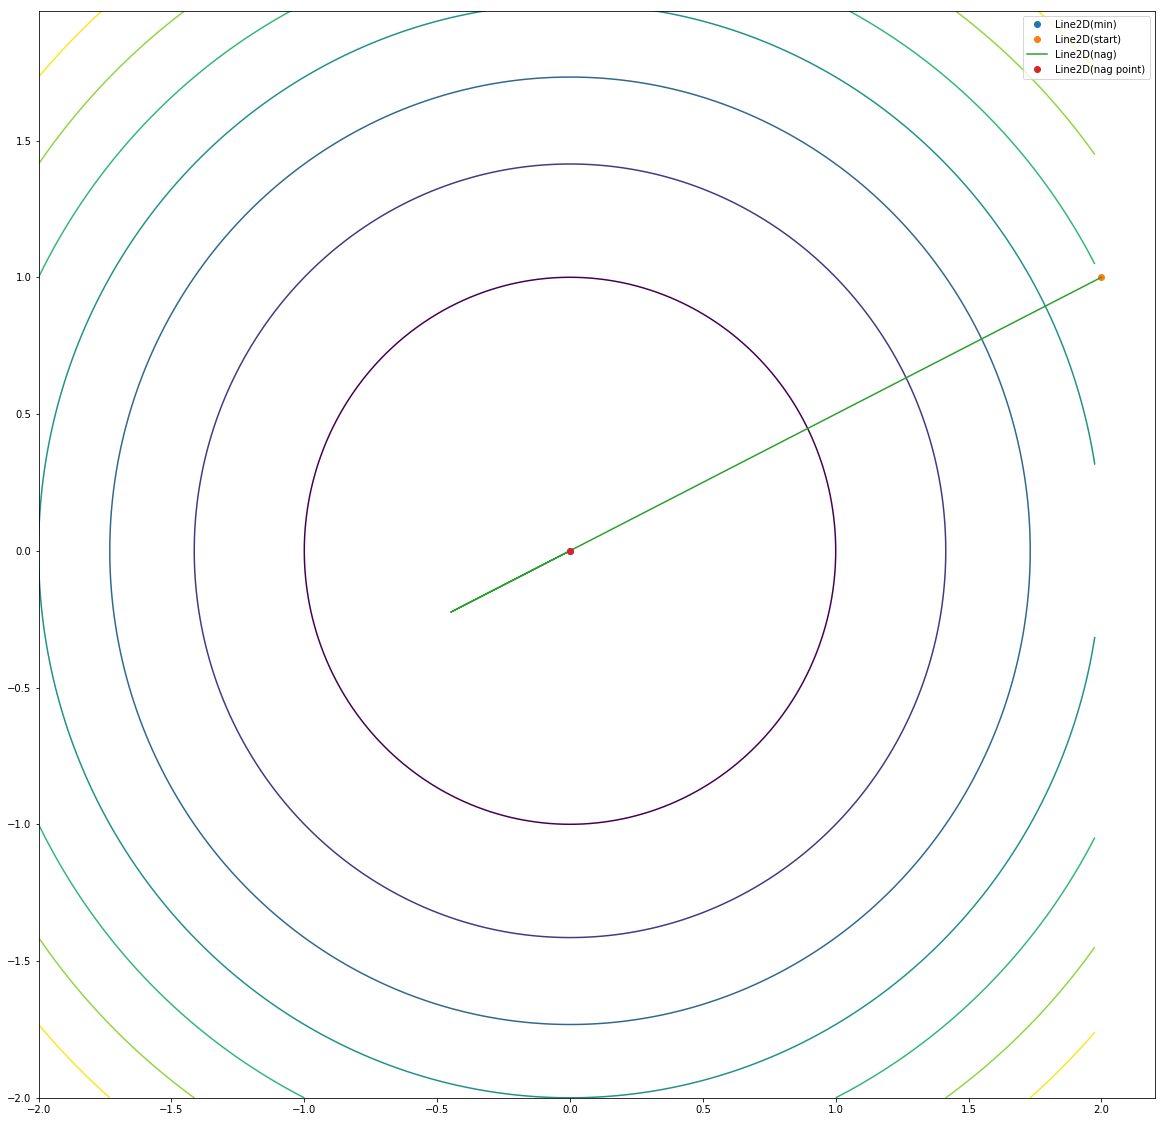

Adagrad : error:  2.58041110997e-58


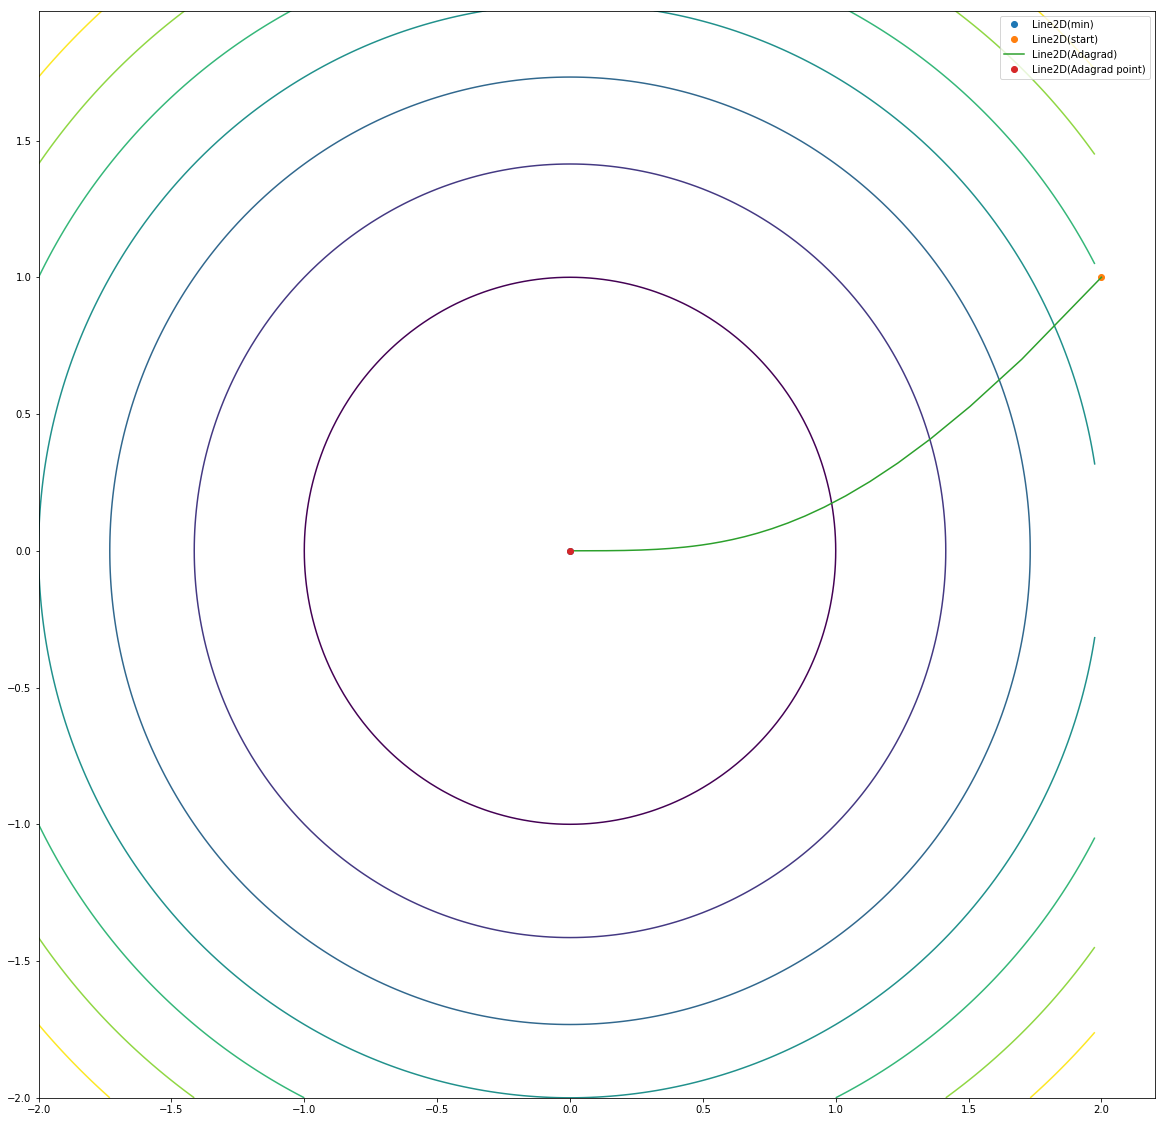

Adadelta : error:  2.4526768493e-18


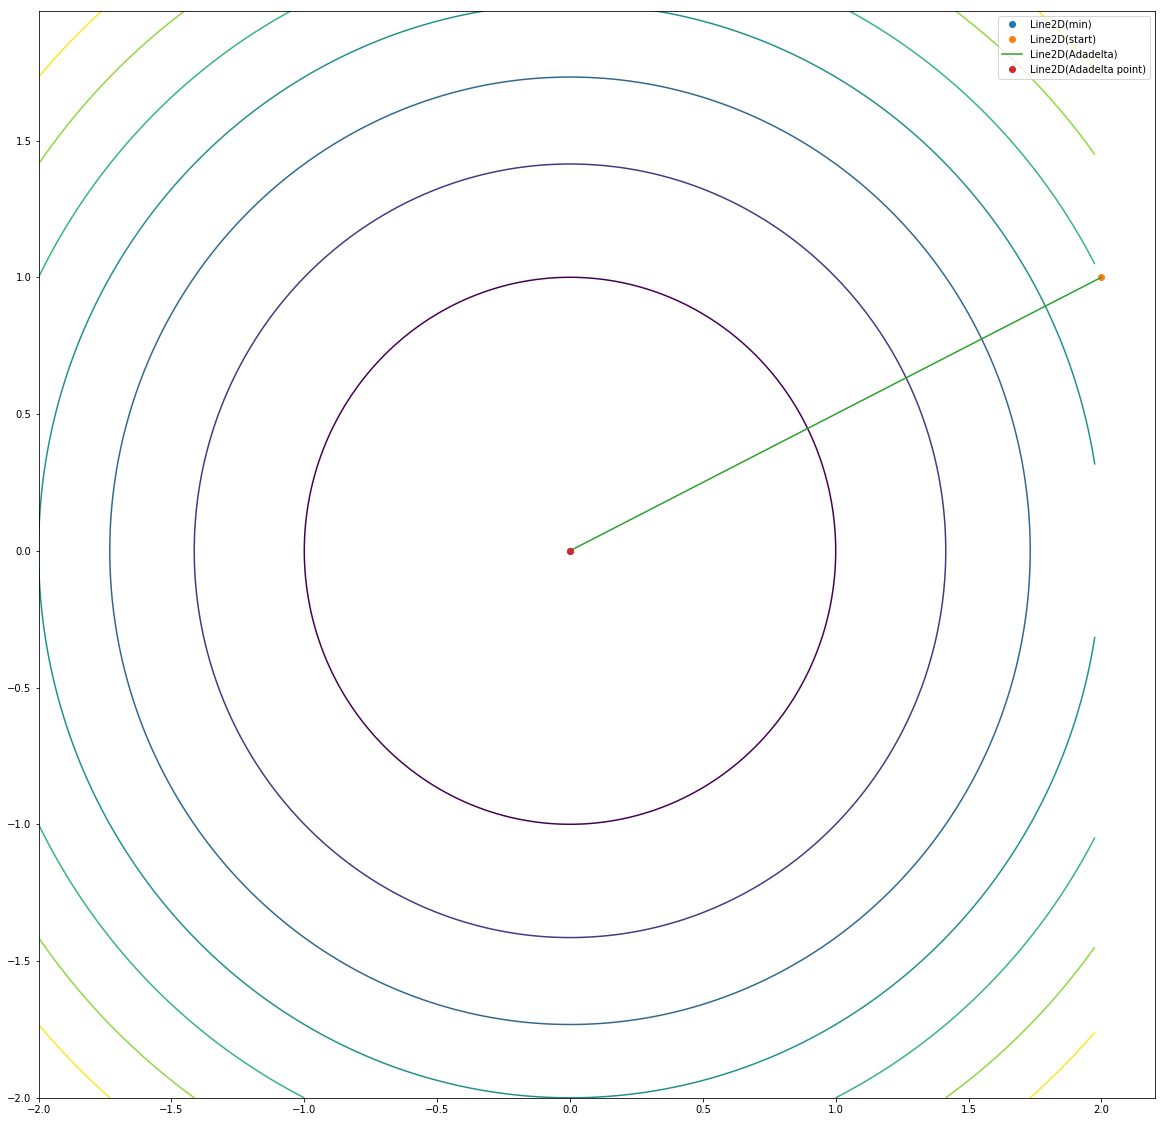

Adam : error:  2.42702399318e-08


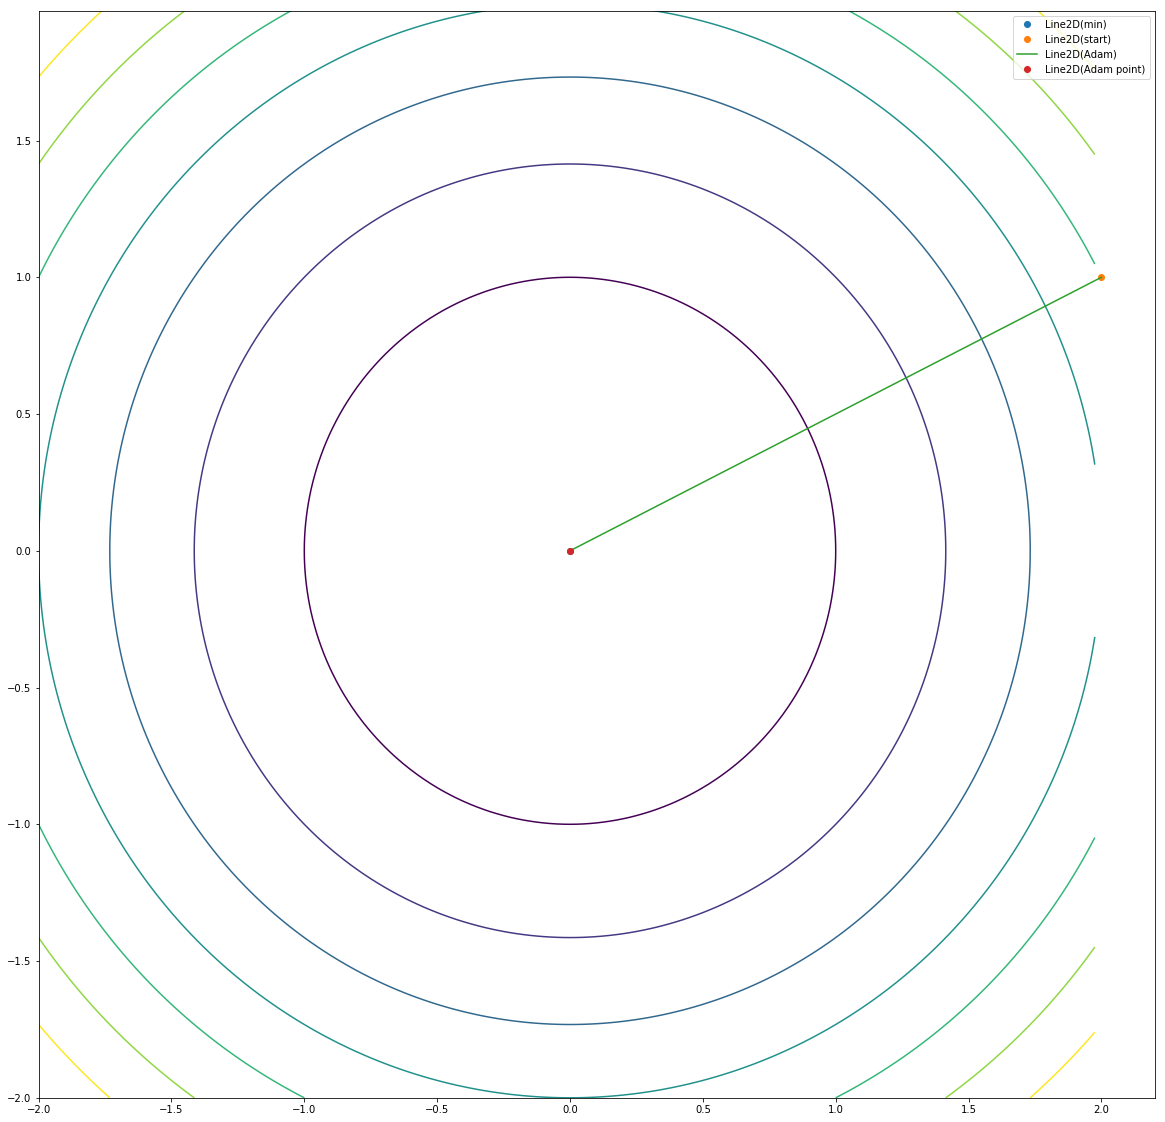

In [13]:
draw (methods, z, np.array ([2,1]))

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [14]:
delta = 0.025
x = np.arange(-5.0, 5.0, delta)
y = np.arange(-5.0, 5.0, delta)
X, Y = np.meshgrid(x, y)

In [15]:
f = lambda X: (X[0]**2)*np.sin(X[0]) + (X[1]**2)*np.sin(X[1])
df = lambda X: np.array([X[0]*(X[0]*np.cos(X[0]) + 2*np.sin(X[0])),
                         X[1]*(X[1]*np.cos(X[1]) + 2*np.sin(X[1]))])
z = (X**2)*np.sin(X) + (Y**2)*np.sin(Y)

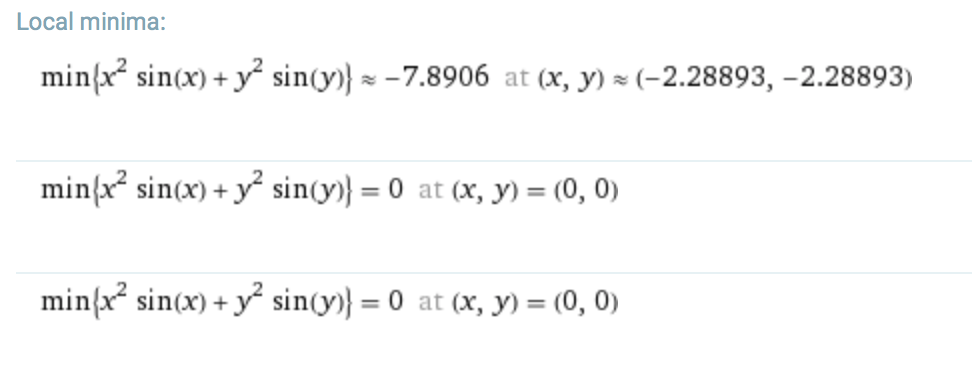

In [16]:
from IPython.display import Image
Image("img.png")

gd : error:  8.78472505439e-05


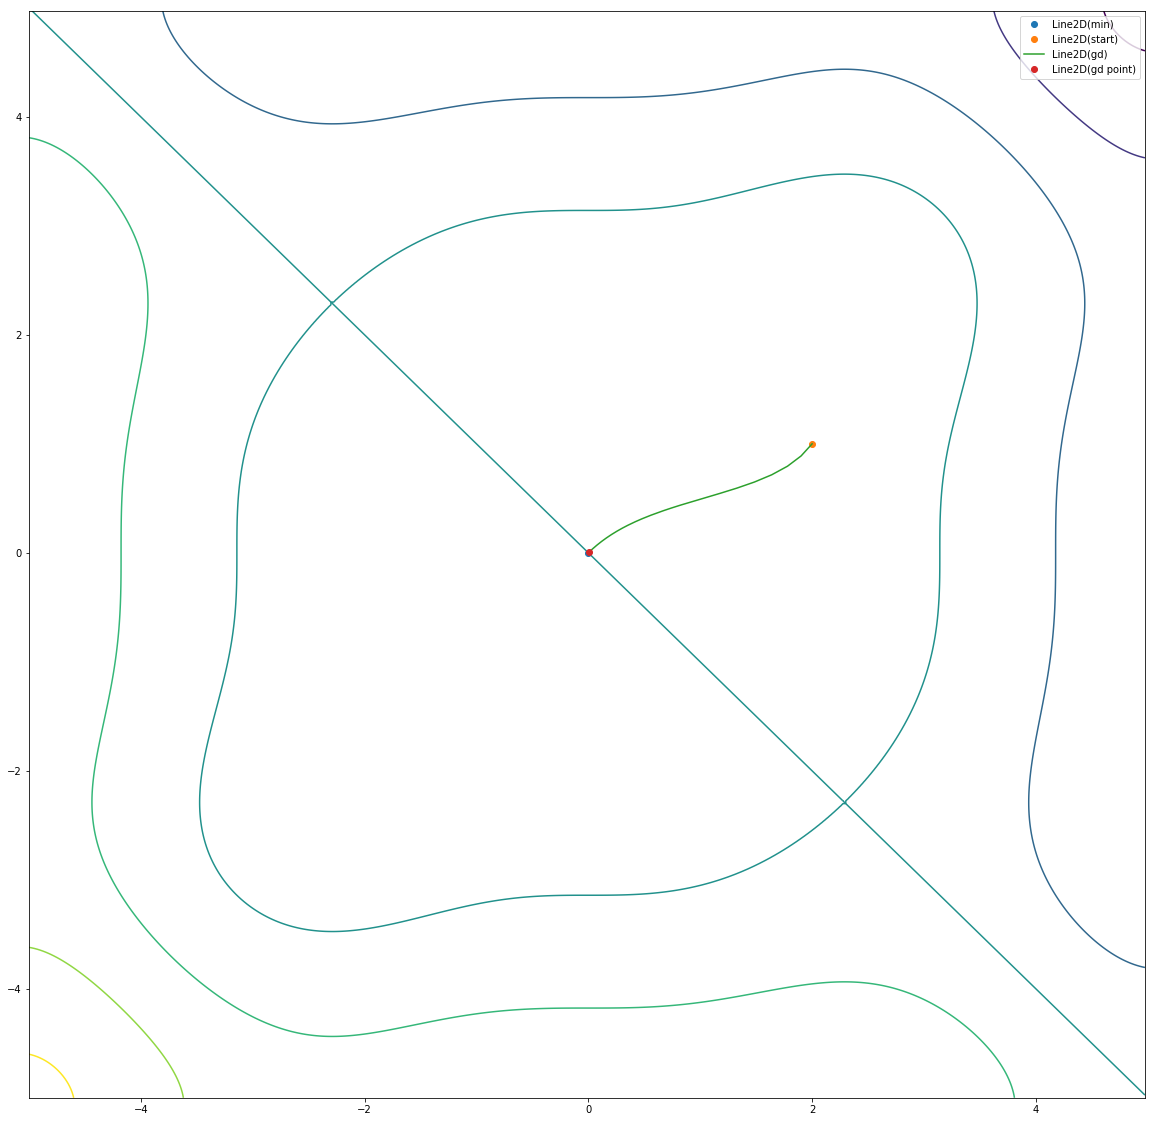

momentum : error:  10.4783986004


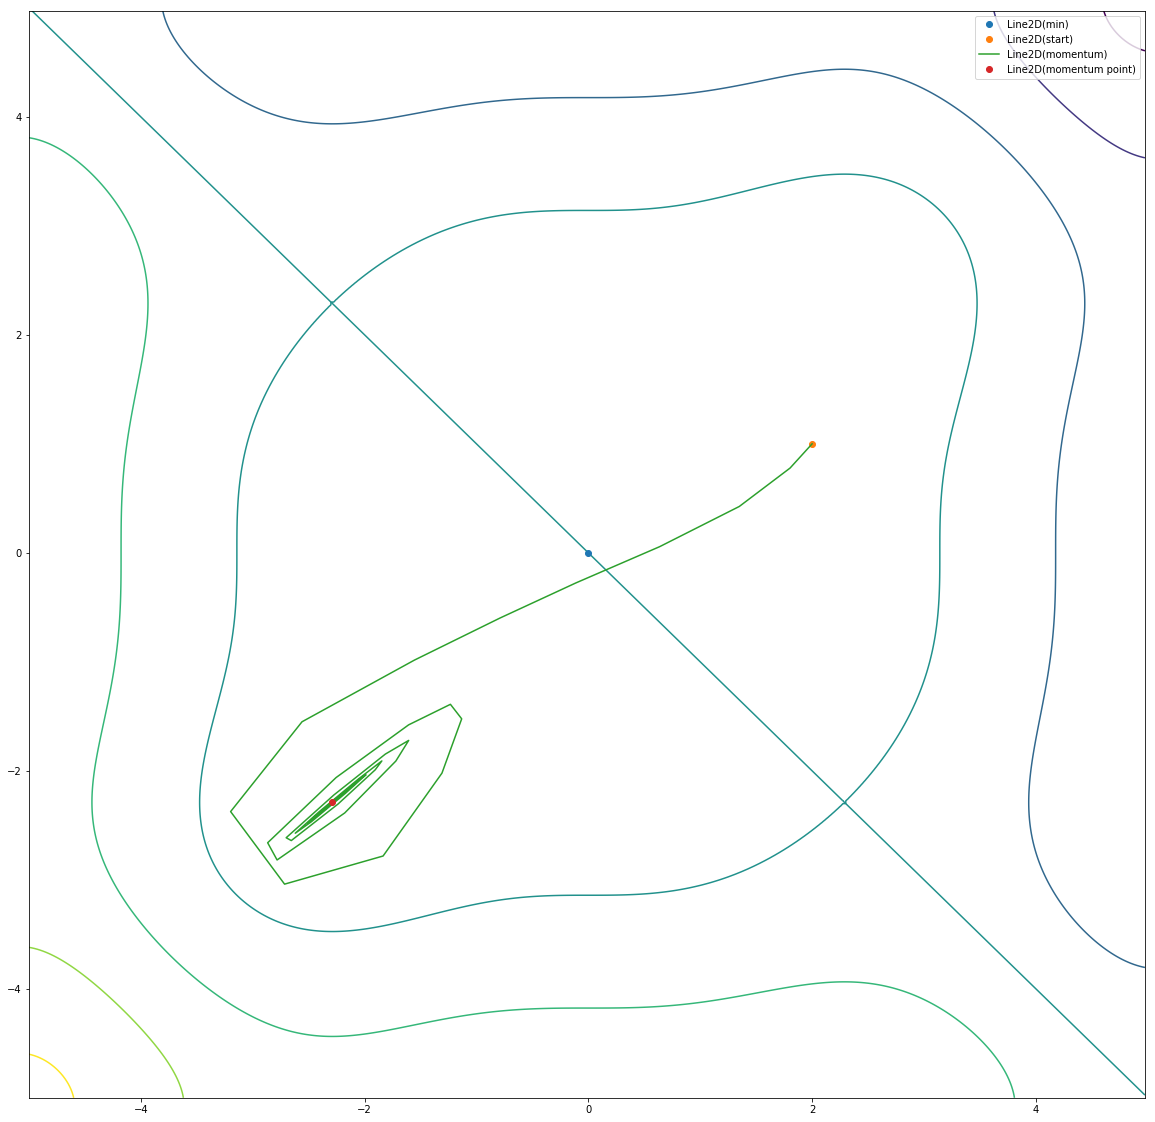

nag : error:  10.4783986004


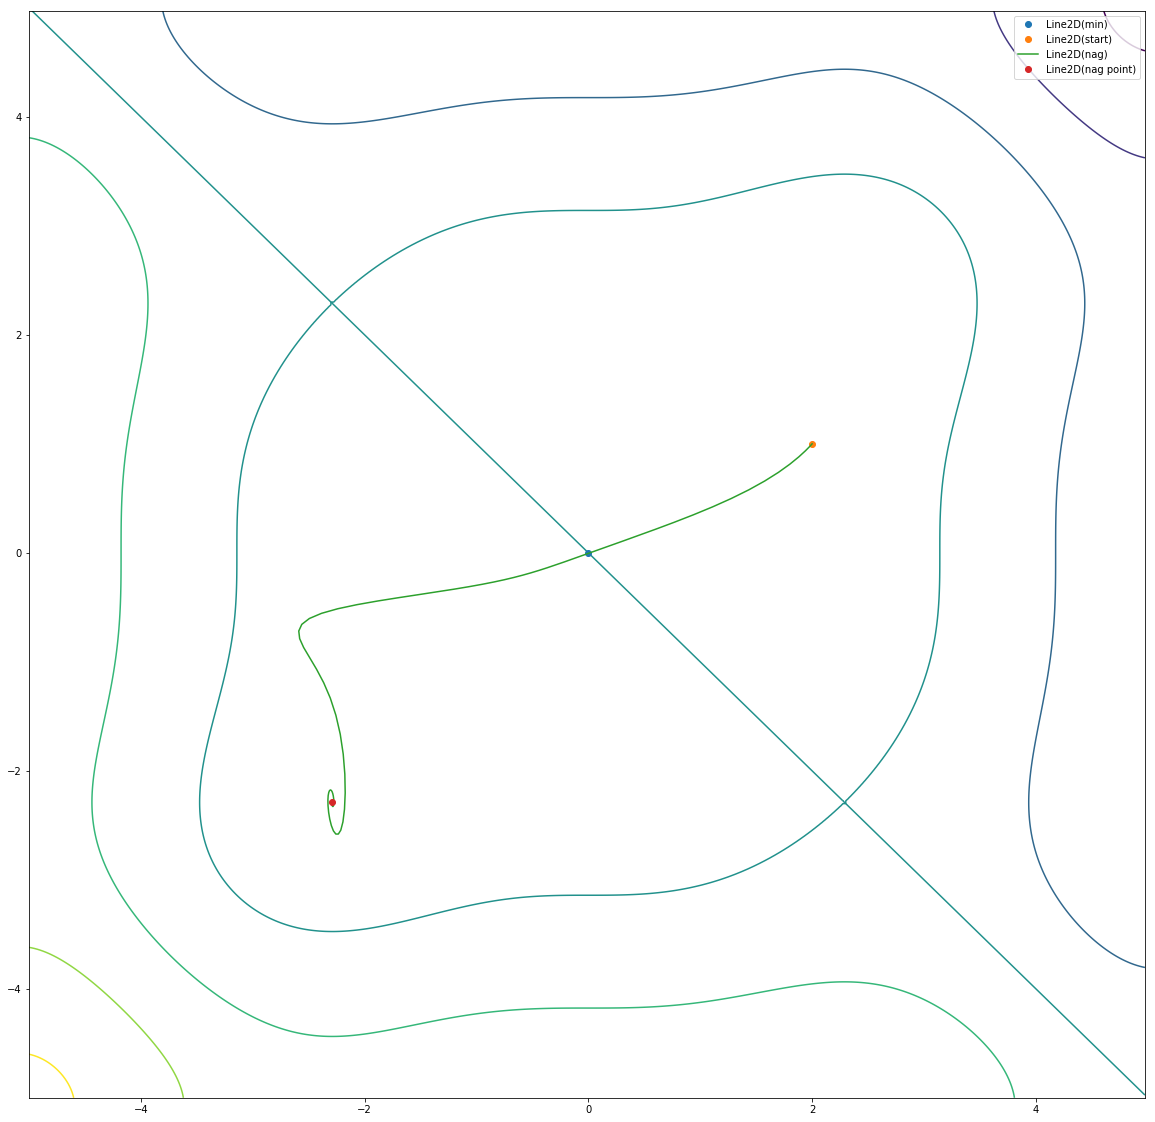

Adagrad : error:  7.88298612418e-05


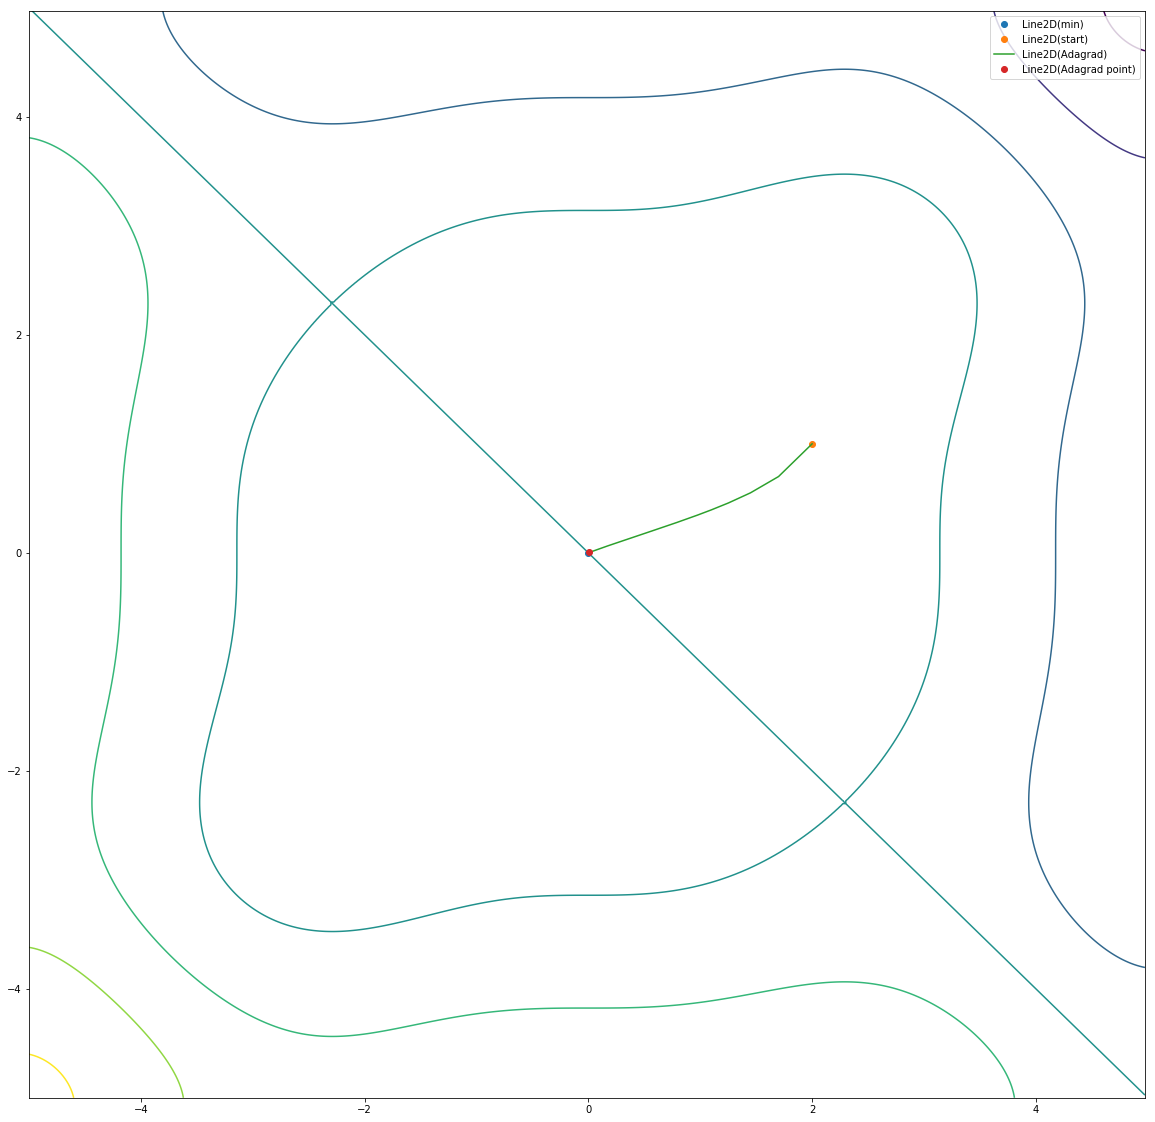

Adadelta : error:  0.00227485618653


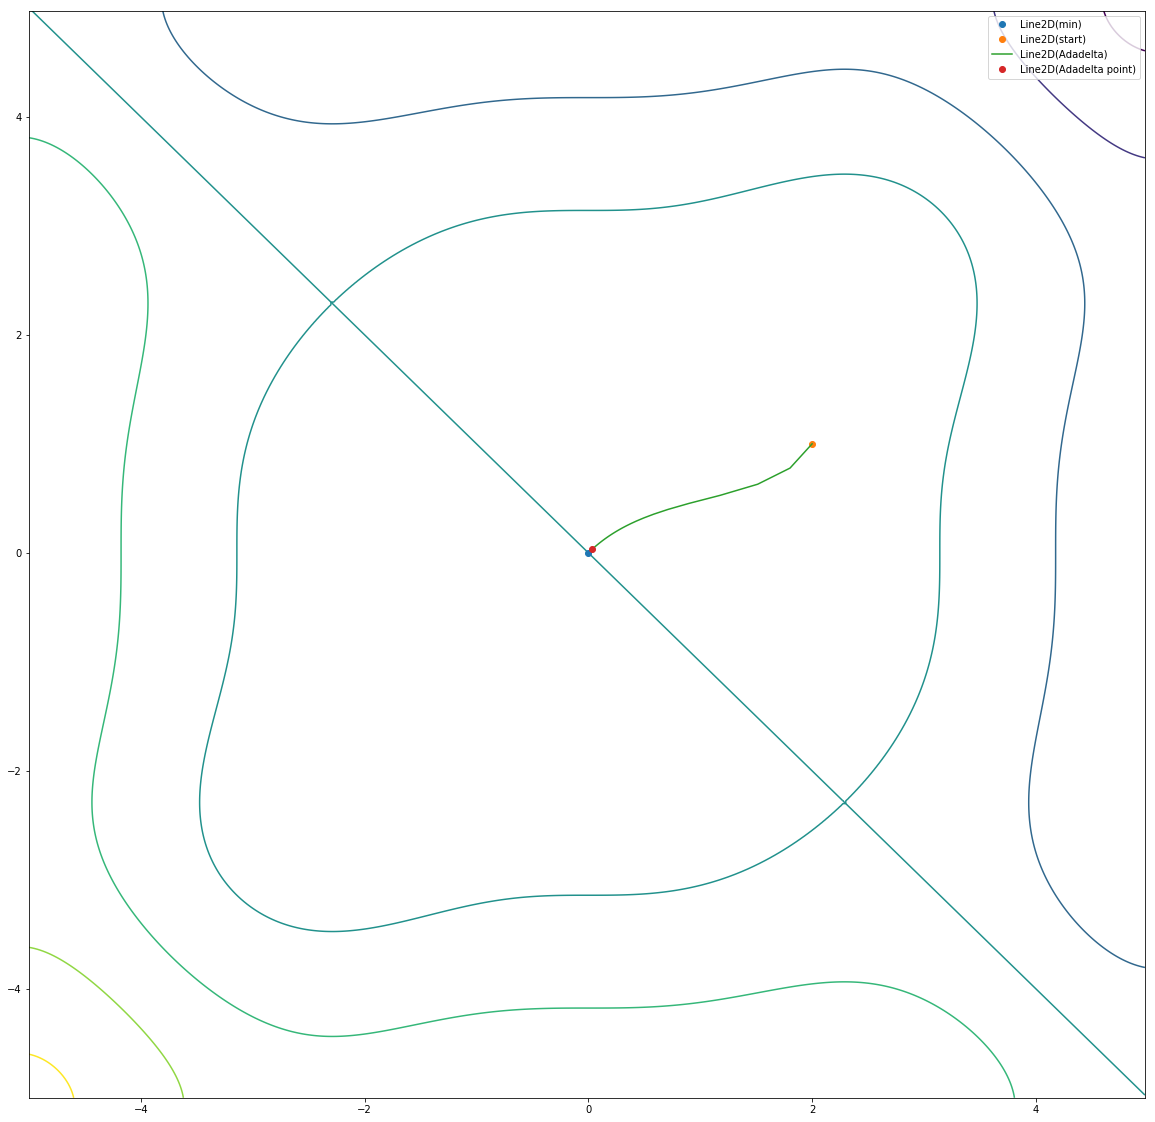

Adam : error:  0.0012284754721


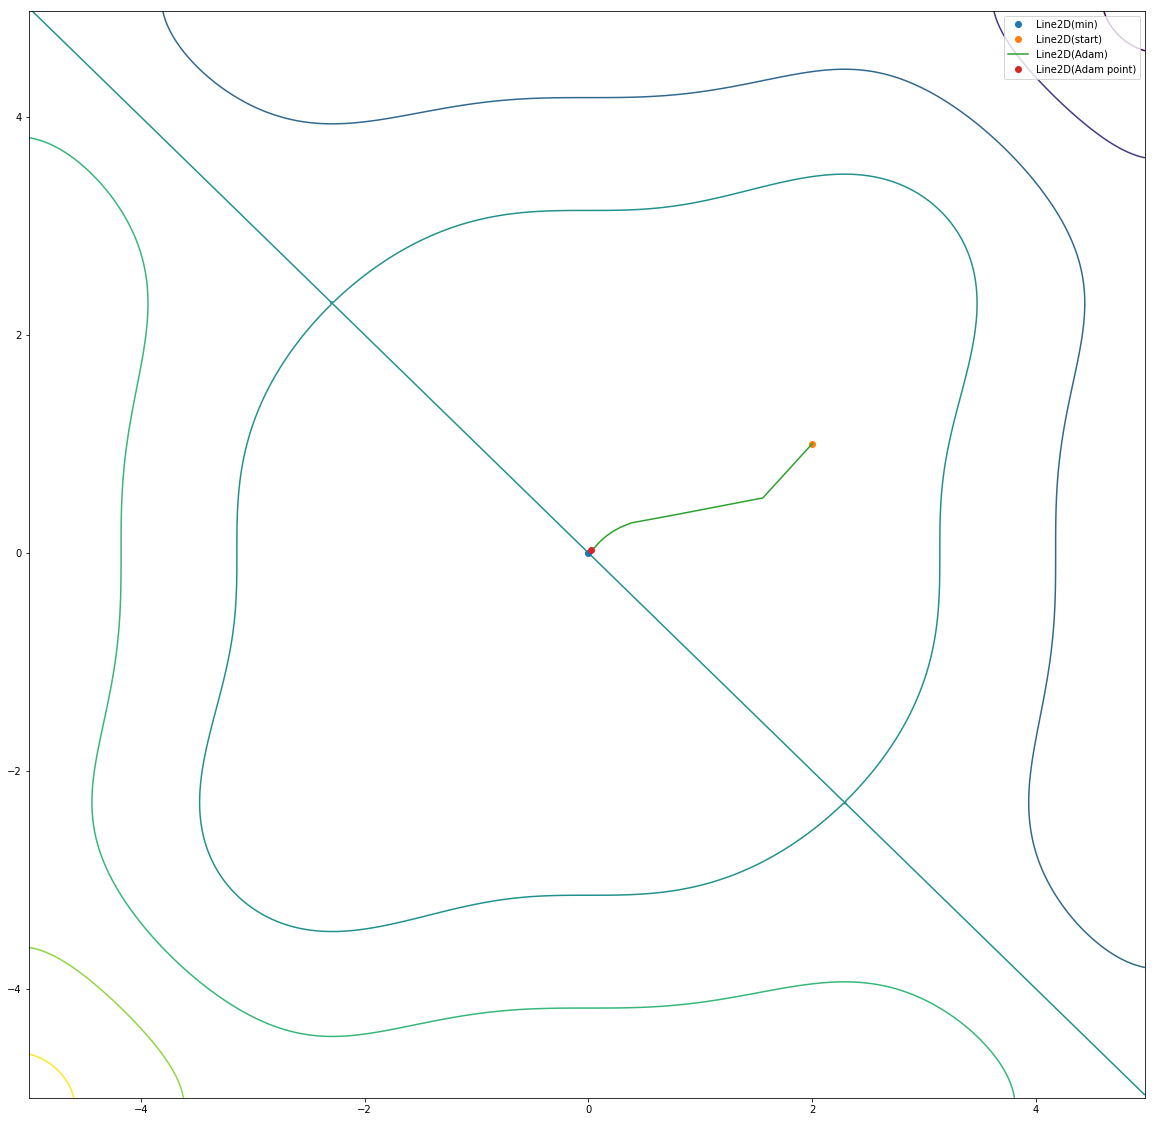

In [17]:
draw (methods, z, np.array ([2,1]))

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

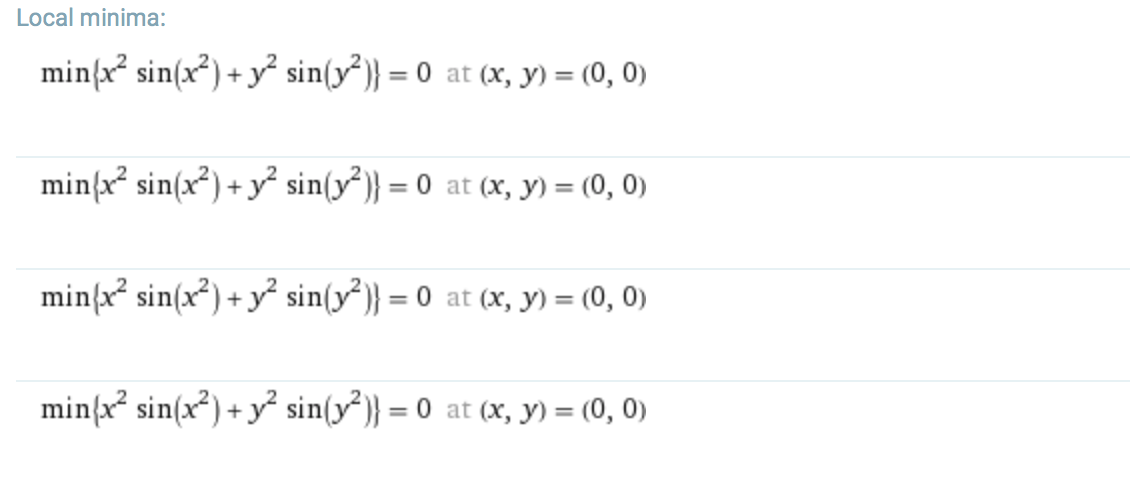

In [18]:
from IPython.display import Image
Image("img2.png")

In [19]:
delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)

In [20]:
f = lambda X: (X[0]**2)*np.sin(X[0]**2) + (X[1]**2)*np.sin(X[1]**2)
df = lambda X: np.array([2 * X[0]*((X[0]**2)*np.cos(X[0]**2) + np.sin(X[0]**2)),
                         2 * X[1]*((X[1]**2)*np.cos(X[1]**2) + np.sin(X[1]**2))])
z = (X**2)*np.sin(X**2) + (Y**2)*np.sin(Y**2)

gd : error:  0.00497033145609


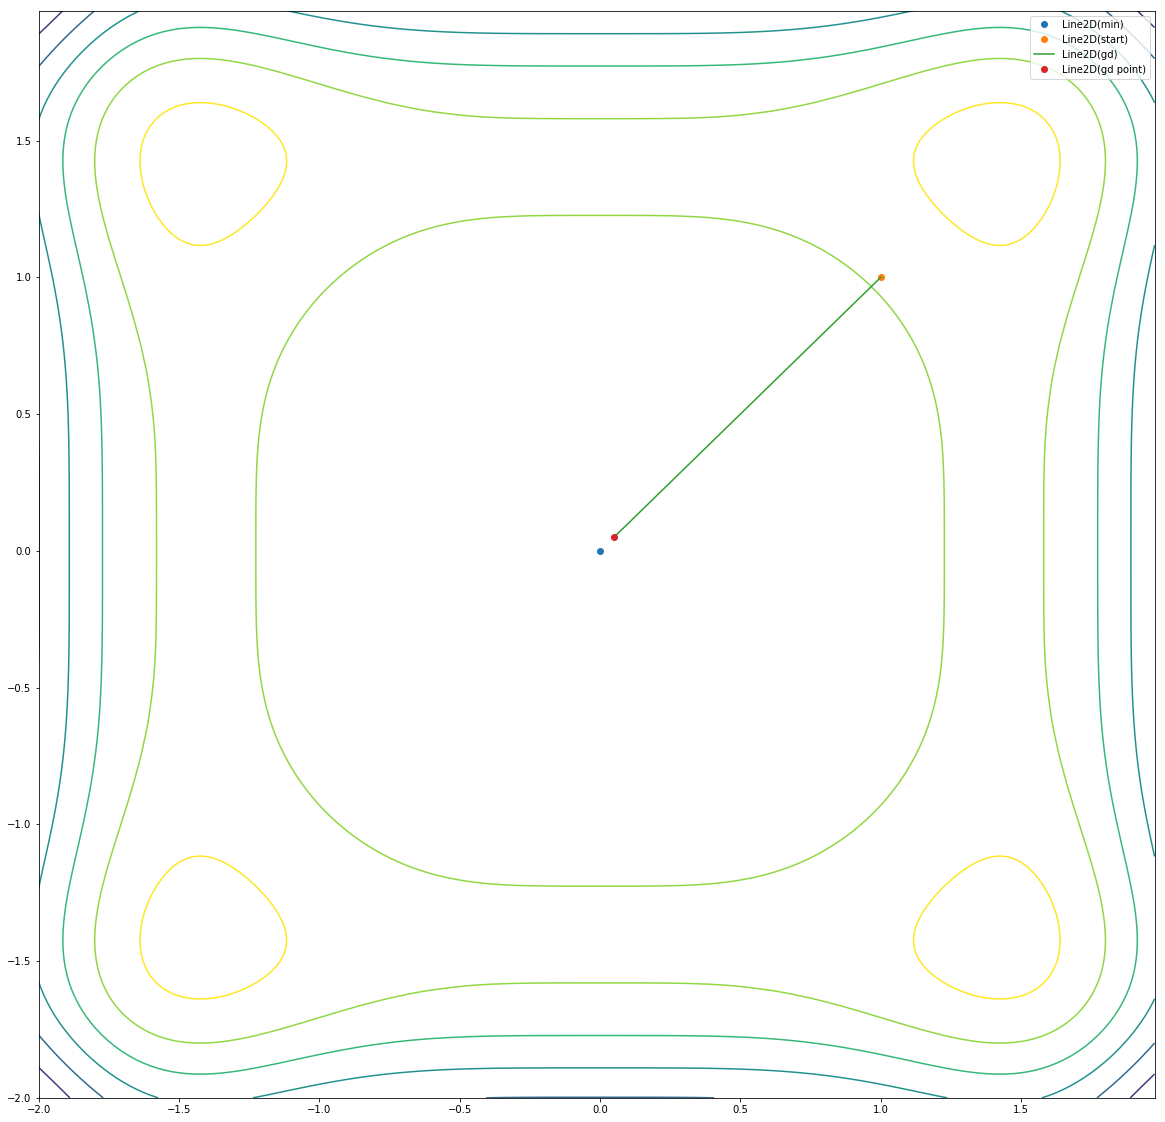

momentum : error:  0.000121424035146


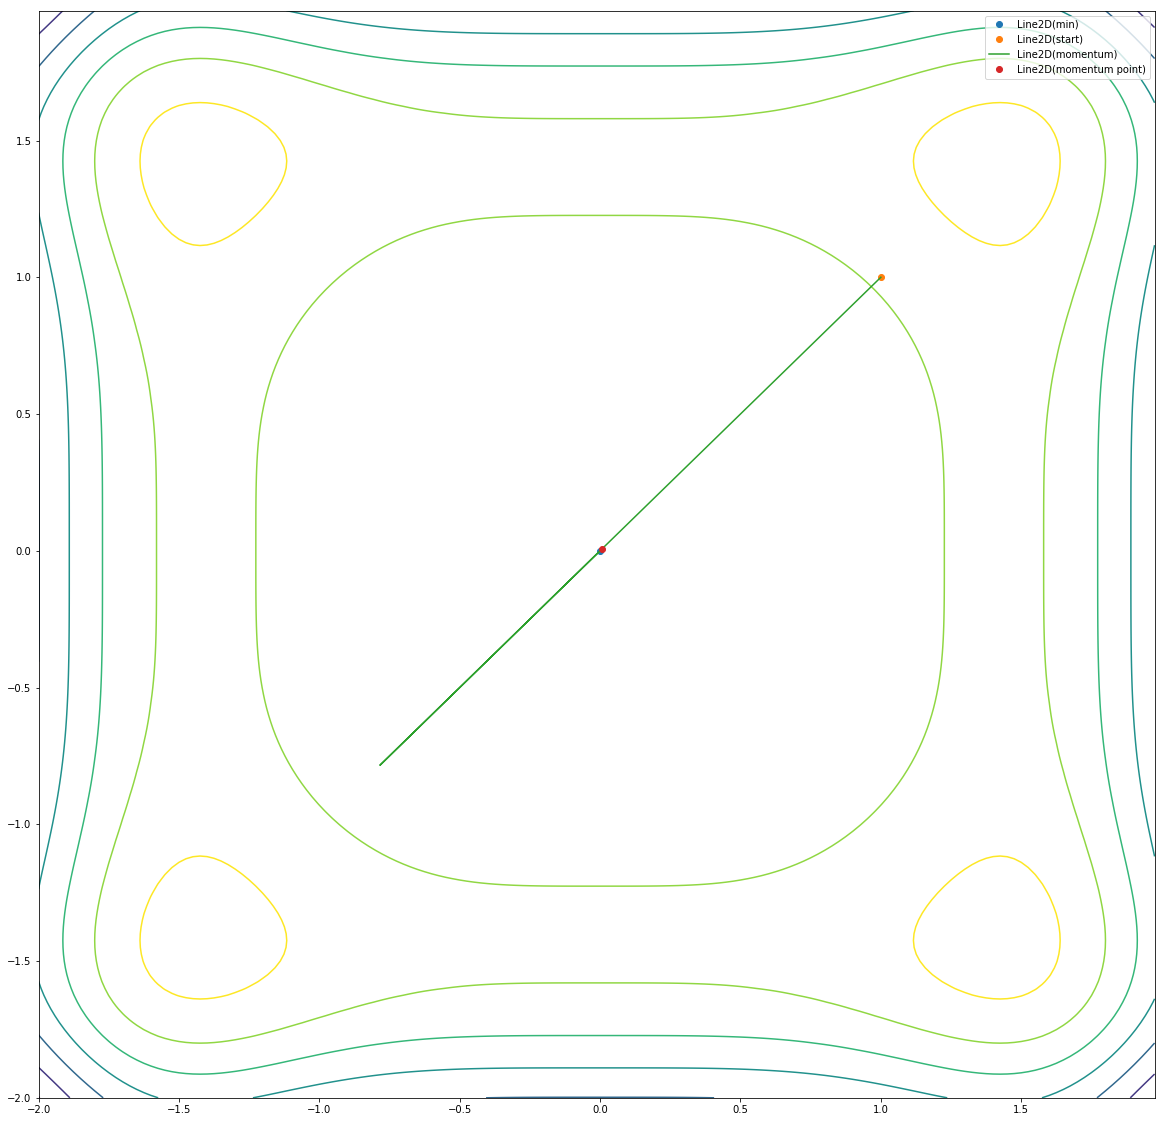

nag : error:  0.00242508353382


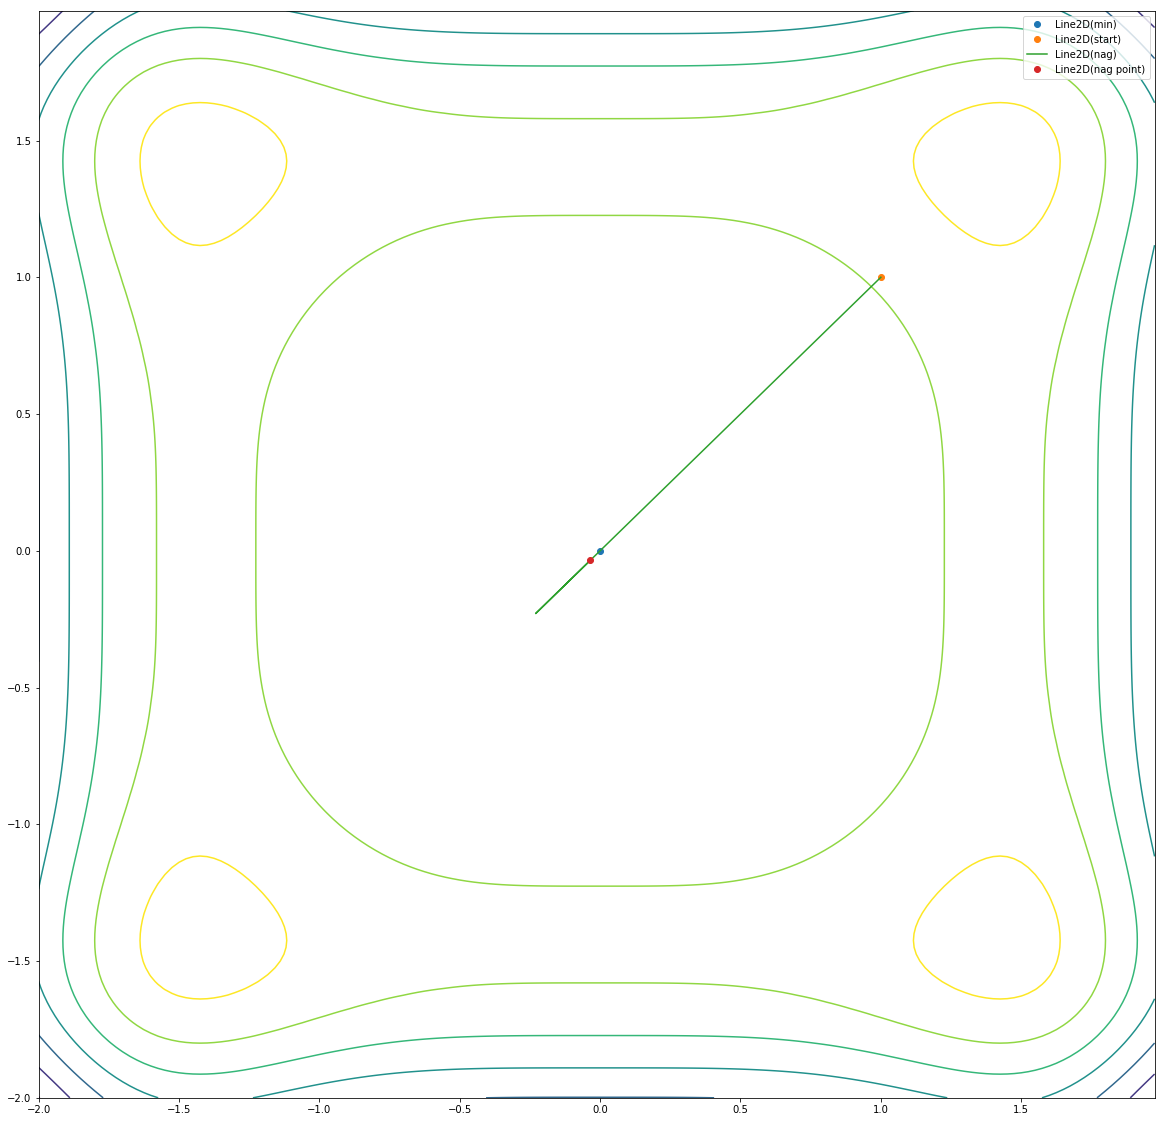

Adagrad : error:  0.00268719573432


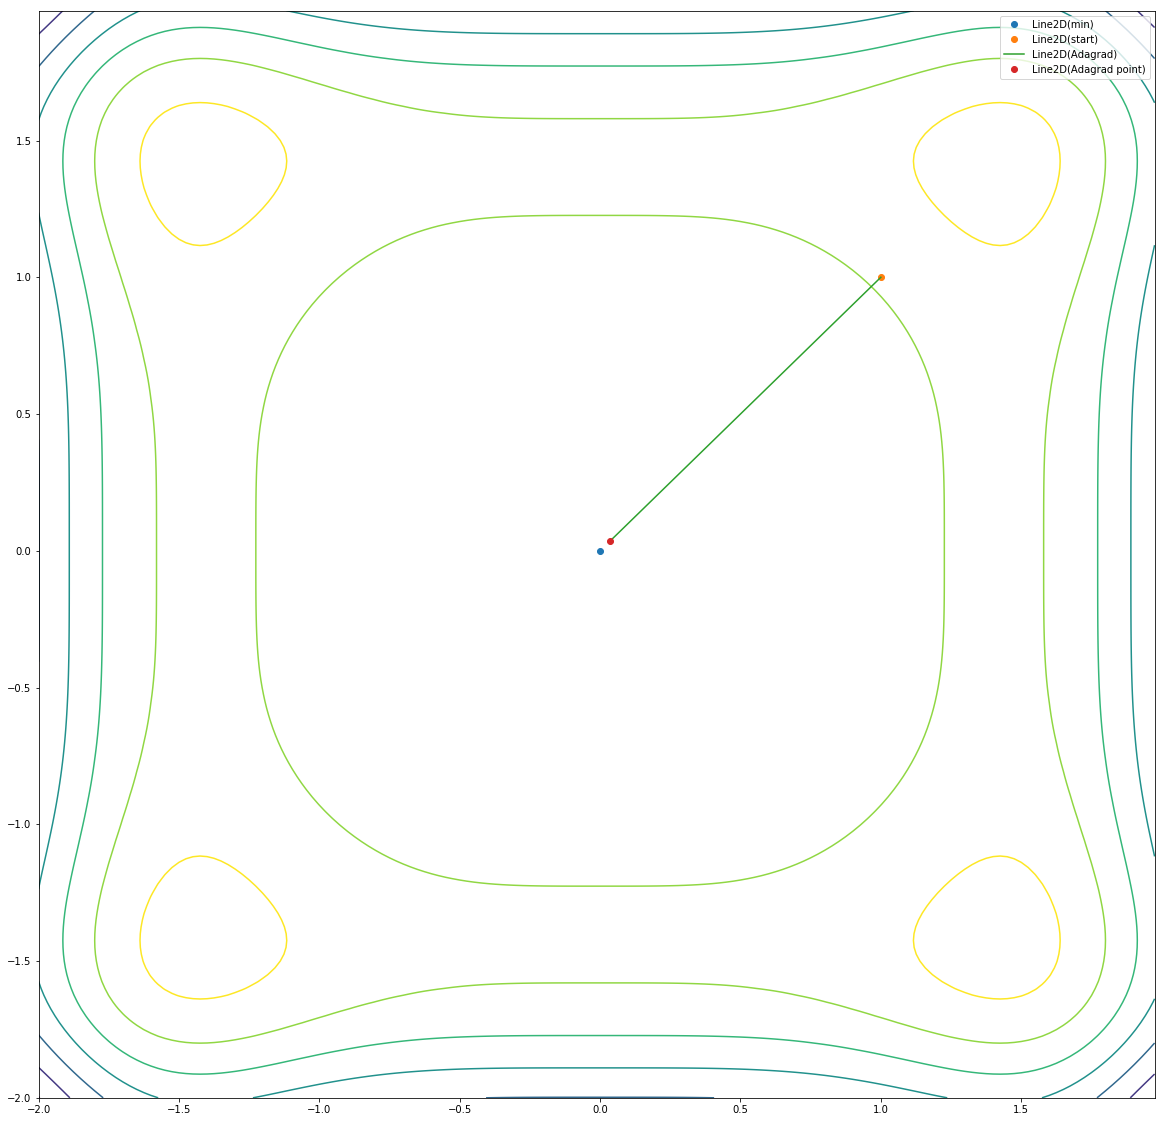

Adadelta : error:  0.0252682038044


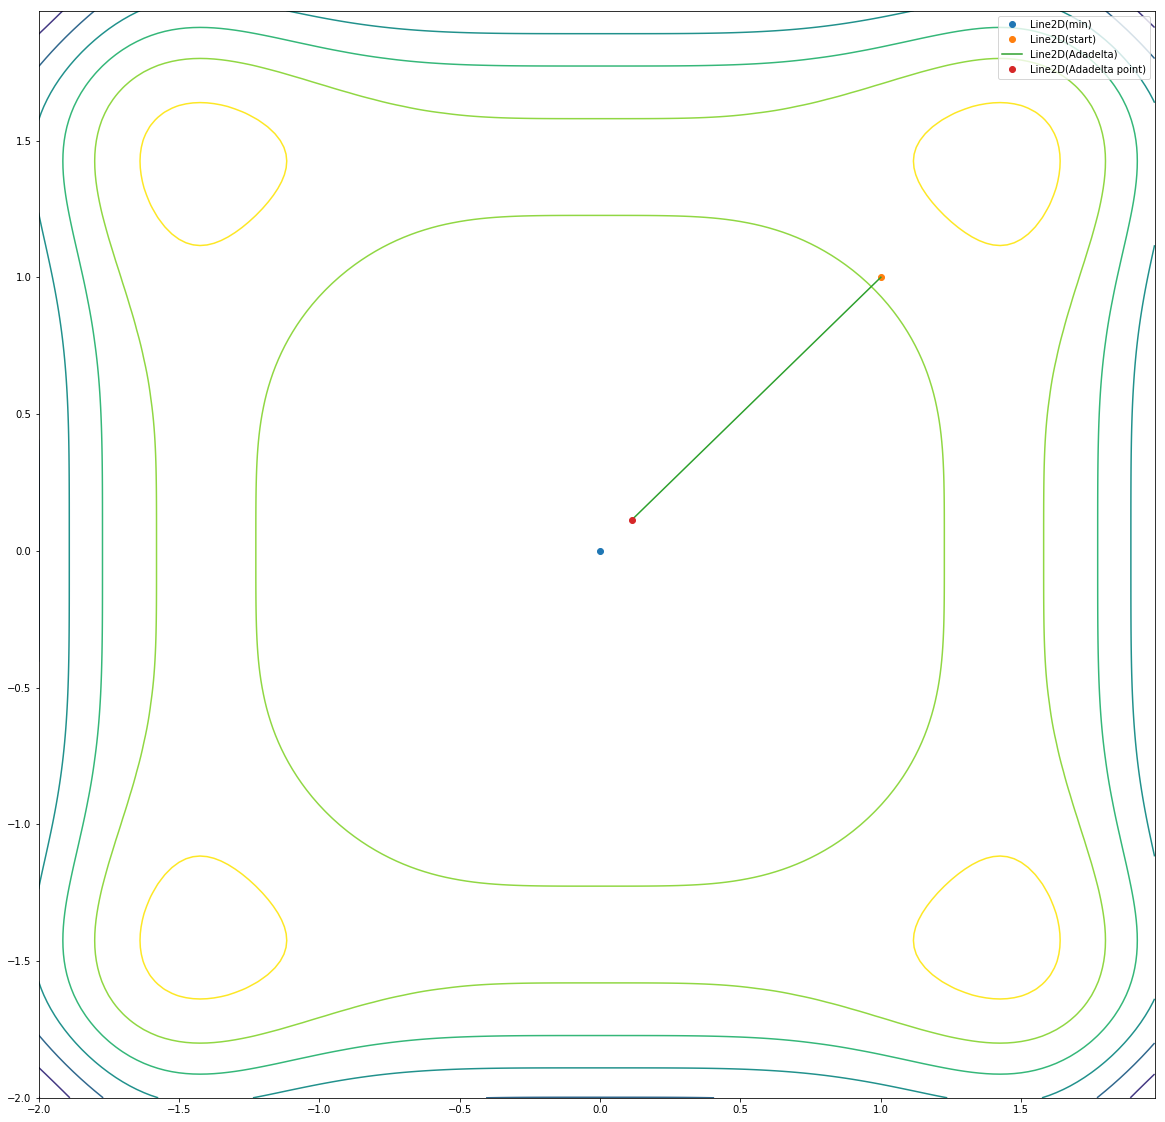

Adam : error:  0.0146191657576


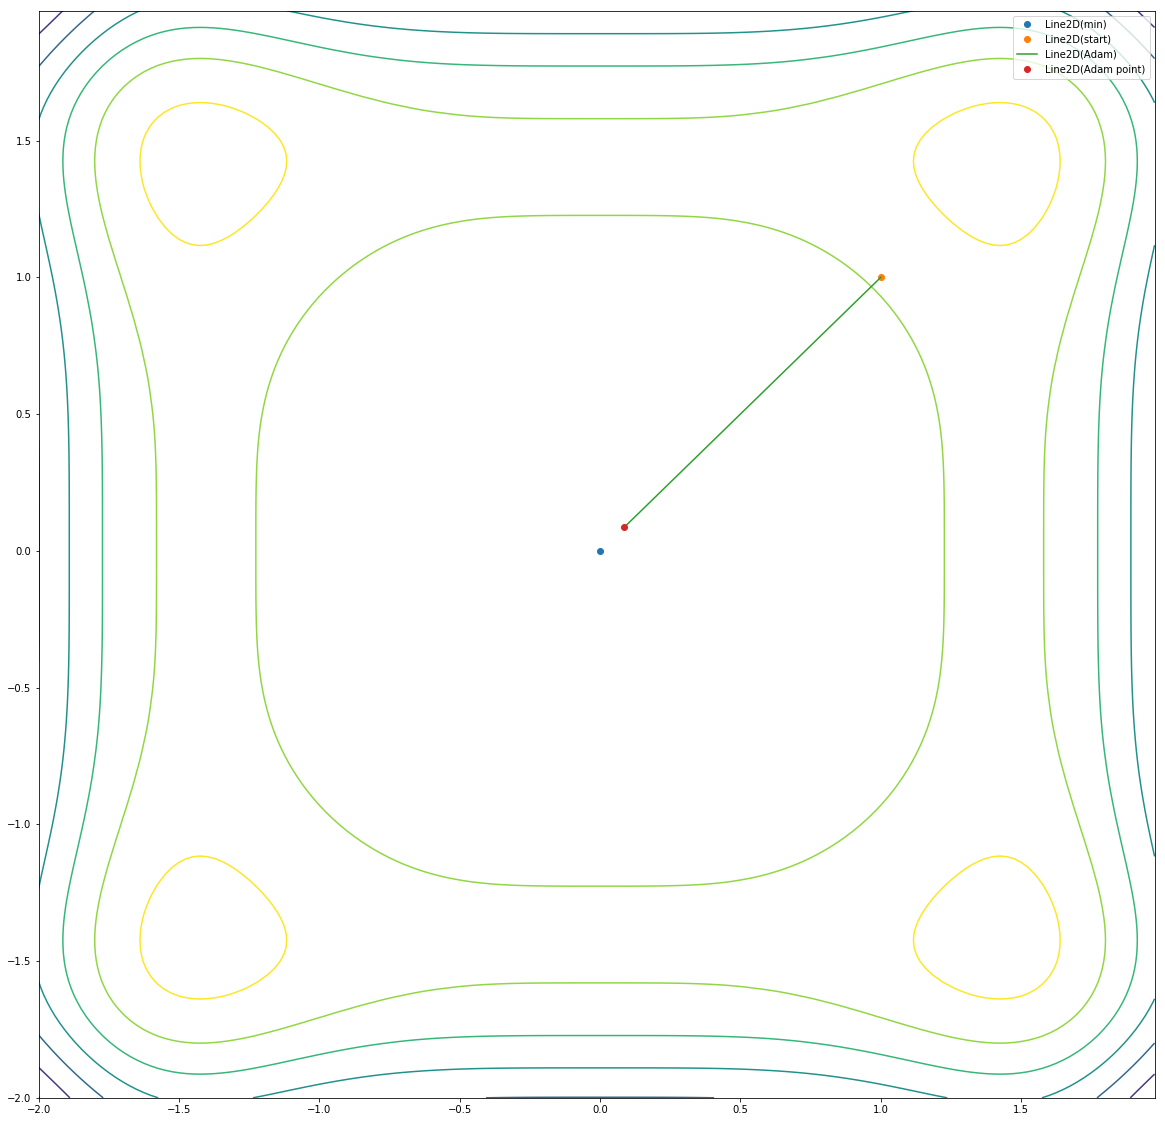

In [21]:
draw (methods, z, np.array ([1,1]))

###  Часть 2: Обучение нейронной сети

In [22]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import torch
import sys
from sklearn.metrics import log_loss
%matplotlib inline

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

loss_fn = torch.nn.NLLLoss()
ClassNum = 10
def run_test (train_loader, model, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    error = []
    for epoch in range (10):
        for batch_idx, (x, target) in enumerate(train_loader):
            x = Variable (x.view(x.size(0), -1), requires_grad=True)
            target = Variable (target, requires_grad=False)
            optimizer.zero_grad ()
            y_pred = model(x)
            loss = loss_fn(y_pred, target)
            loss.backward()
            optimizer.step()
            error.append (loss.data.numpy ().mean ())
            sys.stdout.write ("\repoch {}, loss:{}".format (epoch, loss.data.numpy ().mean ()))


    print ("minimum loss: ", min(error))
    plt.figure (figsize=(15,5))
    plt.plot (error)
    plt.show ()
    
    error = []
    for batch_idx, (x, target) in enumerate(test_loader):
        x = Variable (x.view(x.size(0), -1), requires_grad=True)
        target = Variable (target, requires_grad=False)
        y_pred = model(x)
        loss = loss_fn(y_pred, target)
        error.append (loss.data.numpy ().mean ())

    print ("test error mean: ", np.array (error).mean ())
    plt.figure (figsize=(18,6))
    plt.hist (error, bins=1000, log=True)
    plt.show ()

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, NAG и SGD (на MNIST). </i>

### Adam

In [23]:
layers = []

layers.append (torch.nn.Linear(784,100))
layers.append (torch.nn.Sigmoid ())
layers.append (torch.nn.Linear(100,100))
layers.append (torch.nn.Sigmoid ())
layers.append (torch.nn.Linear(100,10))

loss = torch.nn.NLLLoss()
l_r = 0.01
nn = torch.nn.Sequential (*layers)

epoch 9, loss:0.111328199506('minimum loss: ', 0.051420957)


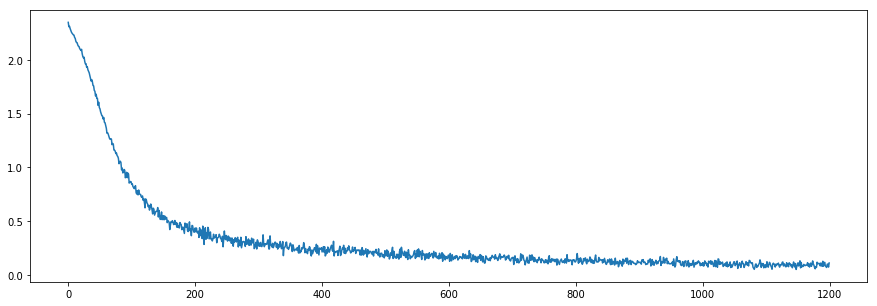

('test error mean: ', 0.11616815)


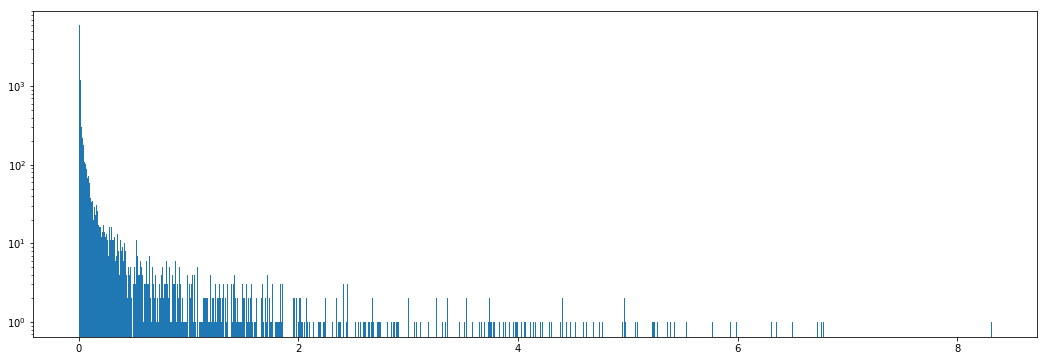

In [24]:
optimizer = torch.optim.Adam(nn.parameters()) 
run_test (train_loader, nn, optimizer)

### SGD

epoch 9, loss:0.405128985643('minimum loss: ', 0.33176833)


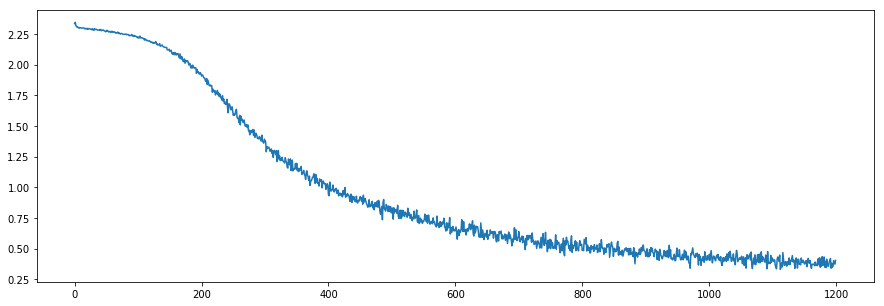

('test error mean: ', 0.36882693)


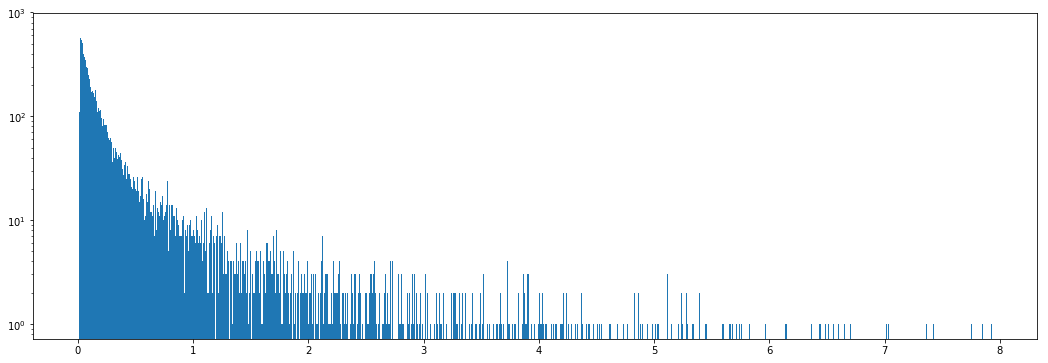

In [25]:
layers = []

layers.append (torch.nn.Linear(784,100))
layers.append (torch.nn.Sigmoid ())
layers.append (torch.nn.Linear(100,100))
layers.append (torch.nn.Sigmoid ())
layers.append (torch.nn.Linear(100,10))

loss = torch.nn.NLLLoss()
l_r = 0.01
nn = torch.nn.Sequential (*layers)

optimizer = torch.optim.SGD(nn.parameters(), lr=0.1) 
run_test (train_loader, nn, optimizer)

### Adadelta

к содалению оптимизатор NAG был удален из библиотеки PYTORCH

epoch 9, loss:0.0996343046427('minimum loss: ', 0.050383057)


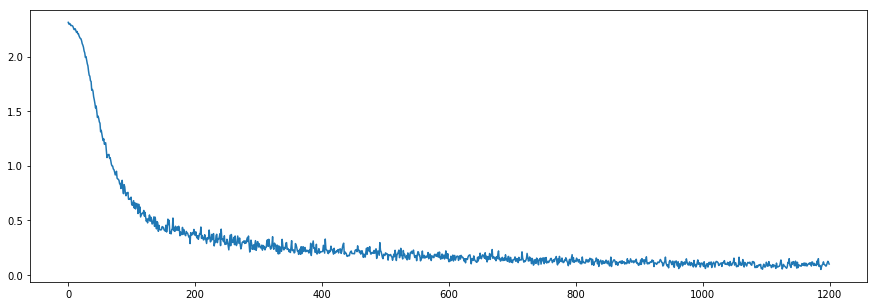

('test error mean: ', 0.10638247)


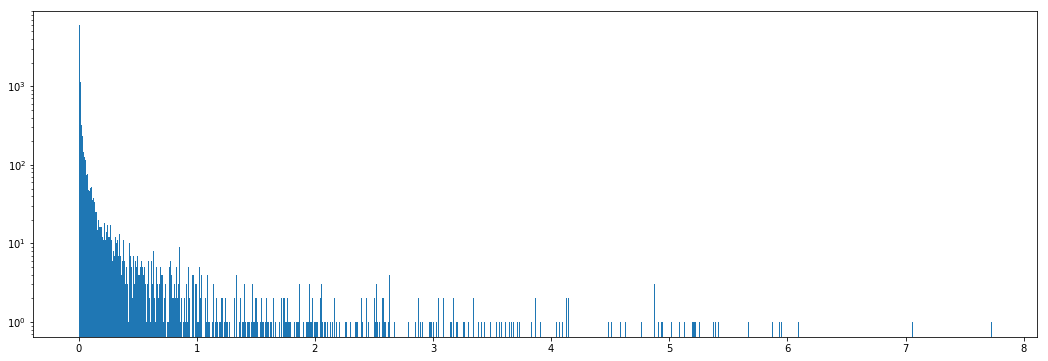

In [26]:
layers = []

layers.append (torch.nn.Linear(784,100))
layers.append (torch.nn.Sigmoid ())
layers.append (torch.nn.Linear(100,100))
layers.append (torch.nn.Sigmoid ())
layers.append (torch.nn.Linear(100,10))

loss = torch.nn.NLLLoss()
l_r = 0.01
nn = torch.nn.Sequential (*layers)

optimizer = torch.optim.Adadelta(nn.parameters()) 
run_test (train_loader, nn, optimizer)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, NAG и SGD. </i>

In [27]:
import torch.nn as nn

In [28]:
class myConvNet_2(nn.Module):
    def __init__(self):
        super(myConvNet_2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(1568, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [33]:
def run_conv_test (network,batch_size,loss_fn,optimizer):
    %matplotlib notebook
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    plt.ion()

    fig.show()
    fig.canvas.draw()

    loss_m = []
    epoch_num = []

    for epoch in range (4):
        for x, y in train_loader:
            optimizer.zero_grad()
            X = Variable(x)
            y = Variable(y, requires_grad=False)
            output = network.forward(X)
            loss = loss_fn(output, y)
            sys.stdout.write (('\r Epoch: {}, Current loss: {}').format (epoch, loss.data.mean ()))
            loss_m.append (loss.data.mean ())


            loss.backward()
            optimizer.step()

            ax.clear() # - Clear
            ax.plot (loss_m)
            for e in epoch_num:
                ax.axvline (e)

            fig.canvas.draw()
        epoch_num.append (len (loss_m))

    %matplotlib inline
    
    error = []
    top_errors = []
    for x, y in test_loader:
            X = Variable(x)
            y = Variable(y, requires_grad=False)
            output = network.forward(X)
            loss = loss_fn(output, y)
            error.append (loss.data.mean ())
    print "error mean:", np.array (error).mean ()
    plt.hist (error,bins=1000,log=True)

<IPython.core.display.Javascript object>


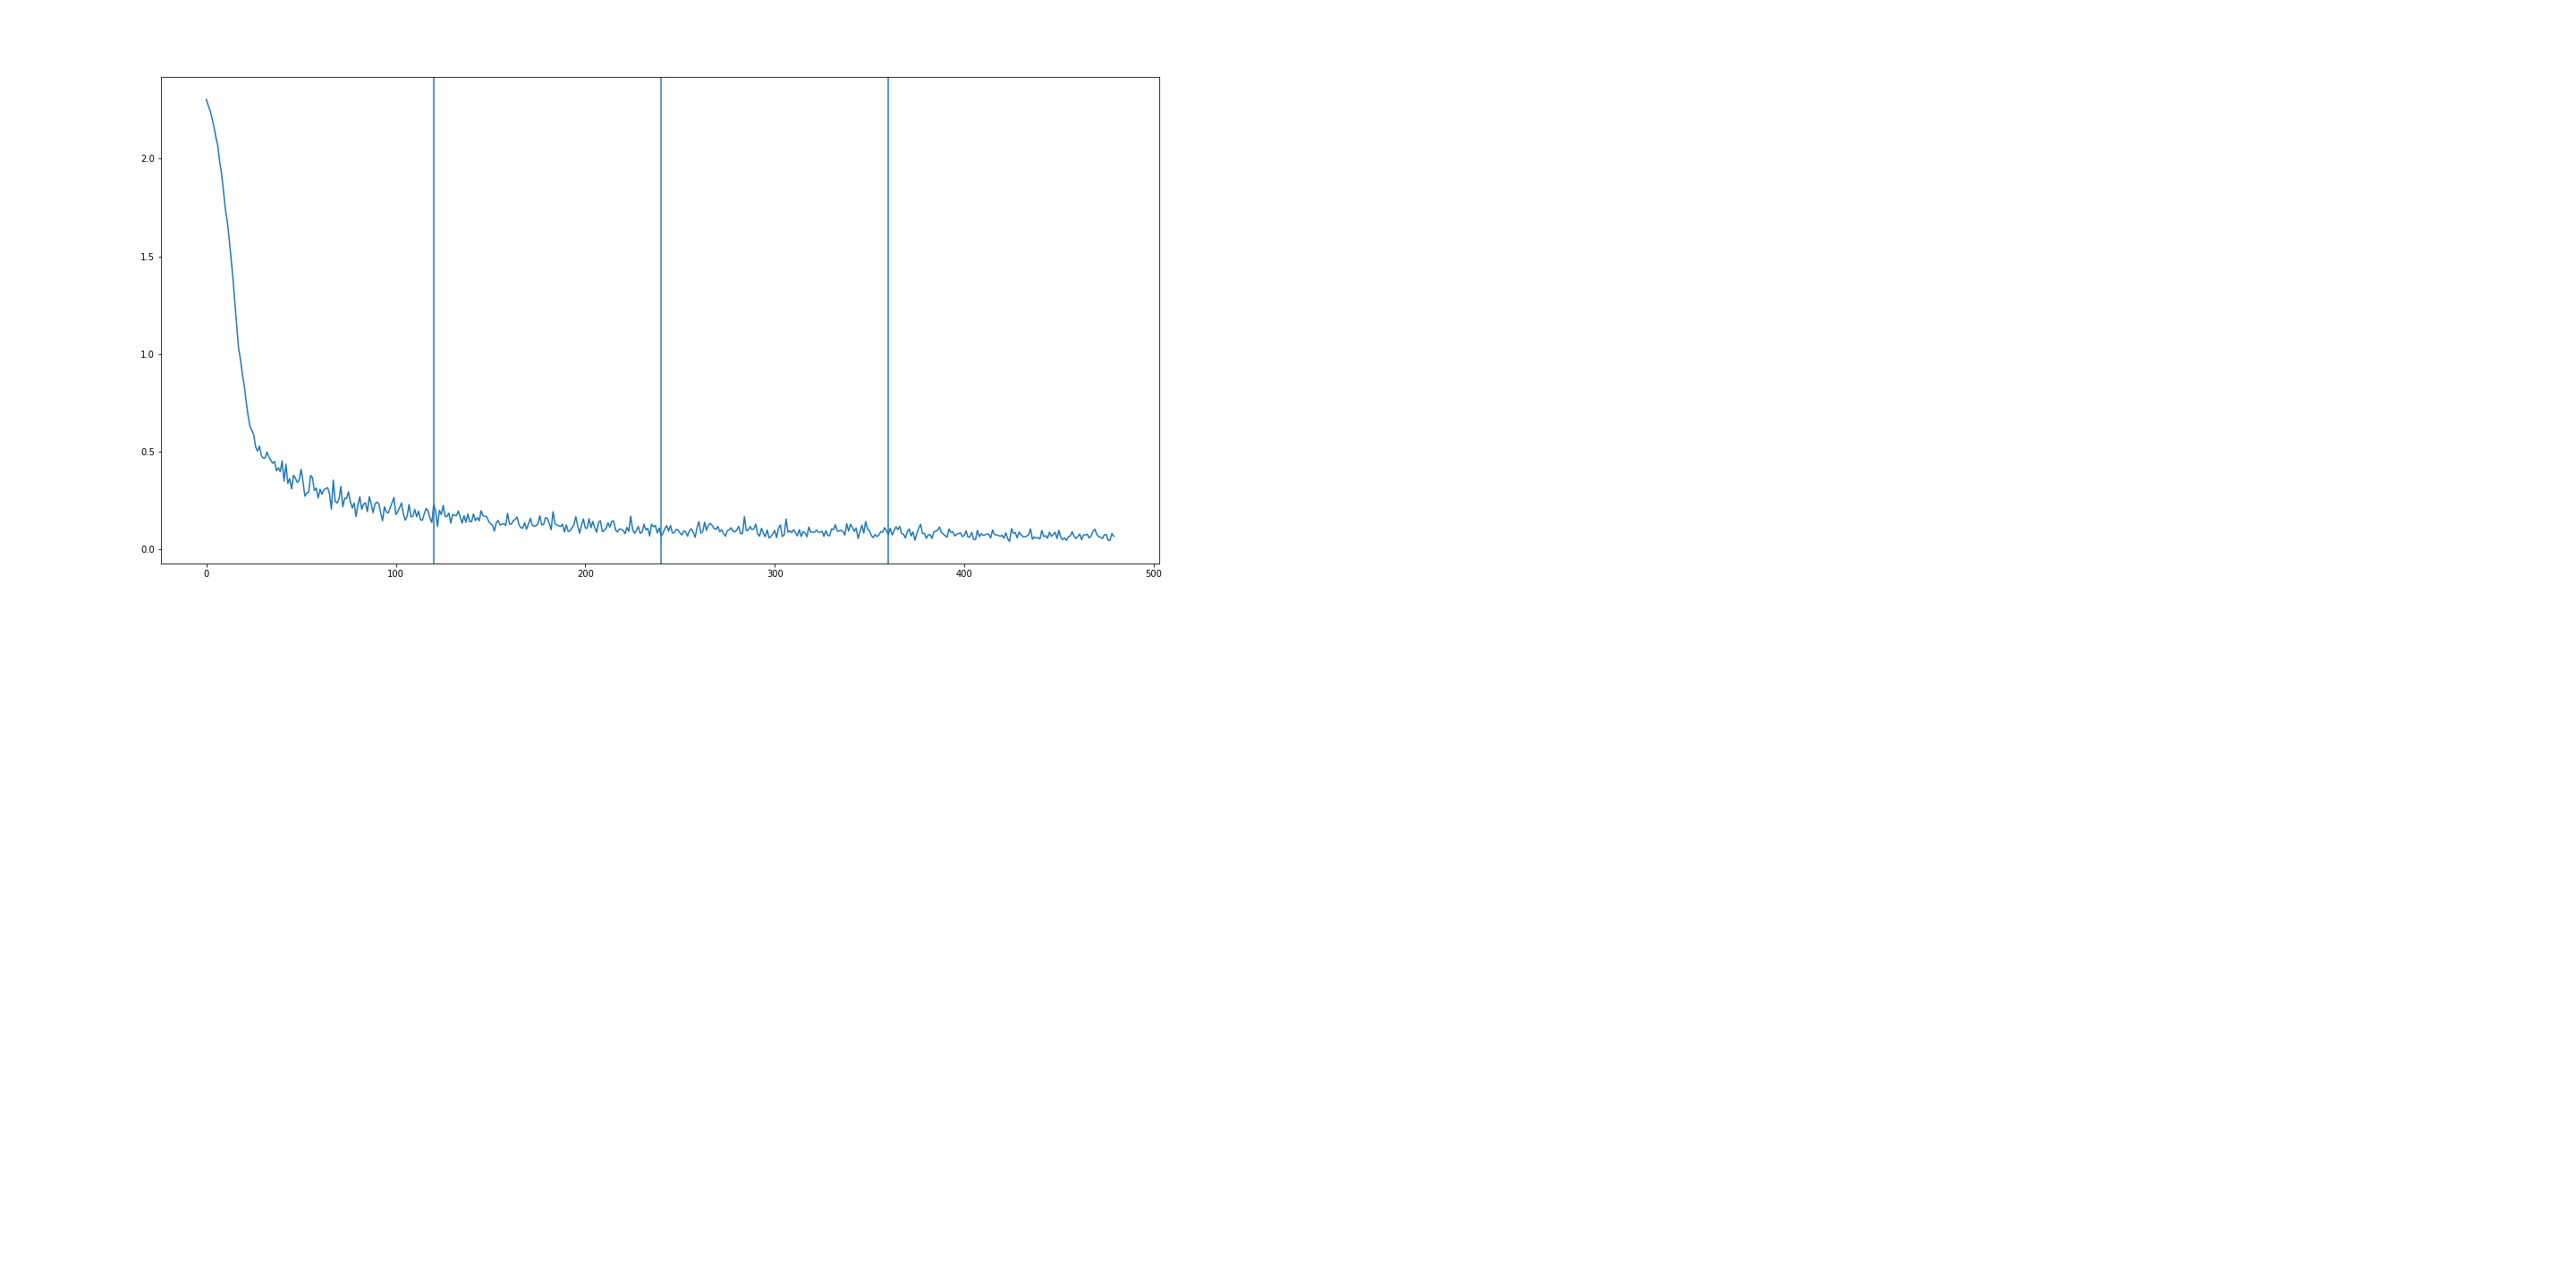

 Epoch: 3, Current loss: 0.0661678239703error mean: 0.0562546356943


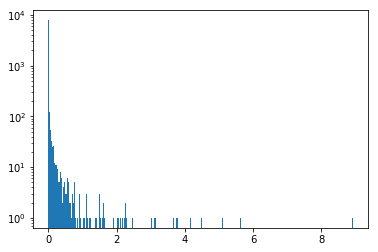

In [34]:
network = myConvNet_2()
batch_size = 10
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

run_conv_test (network,batch_size,loss_fn,optimizer)

### SGD

<IPython.core.display.Javascript object>


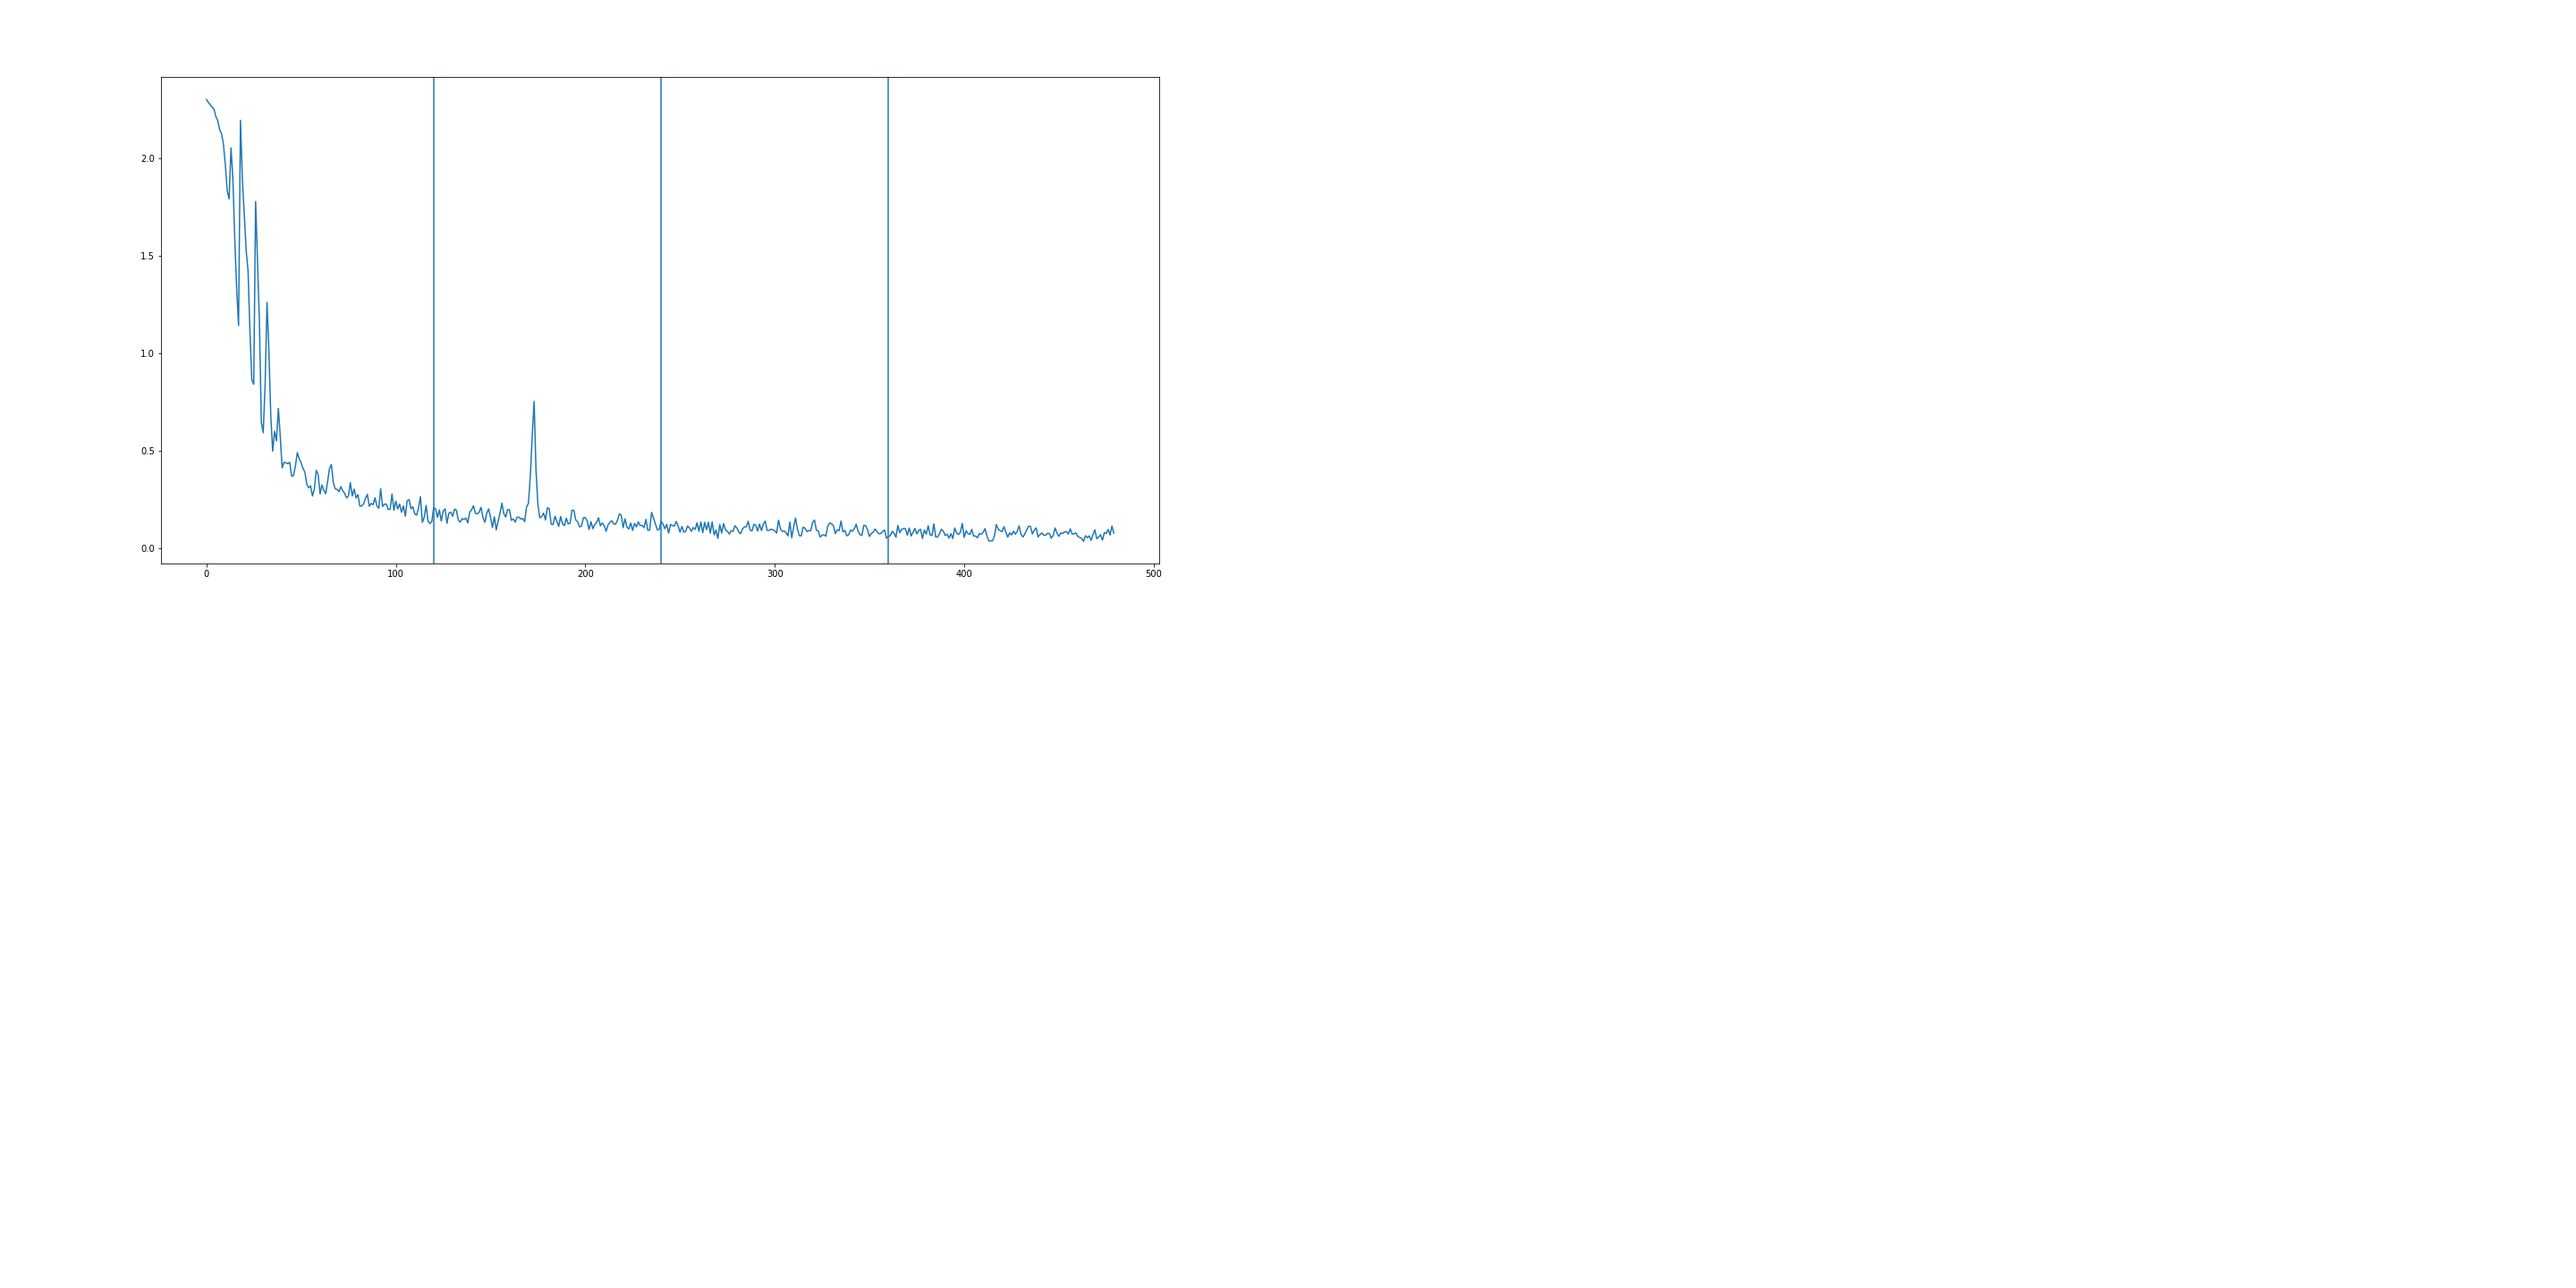

 Epoch: 3, Current loss: 0.0797577202326error mean: 0.0699764372431


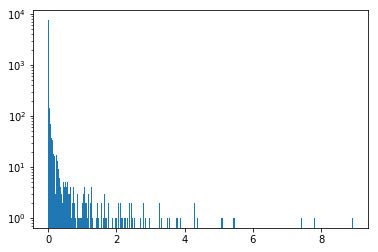

In [35]:
network = myConvNet_2()
batch_size = 10
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1) 

run_conv_test (network,batch_size,loss_fn,optimizer)

### Adadelta

<IPython.core.display.Javascript object>


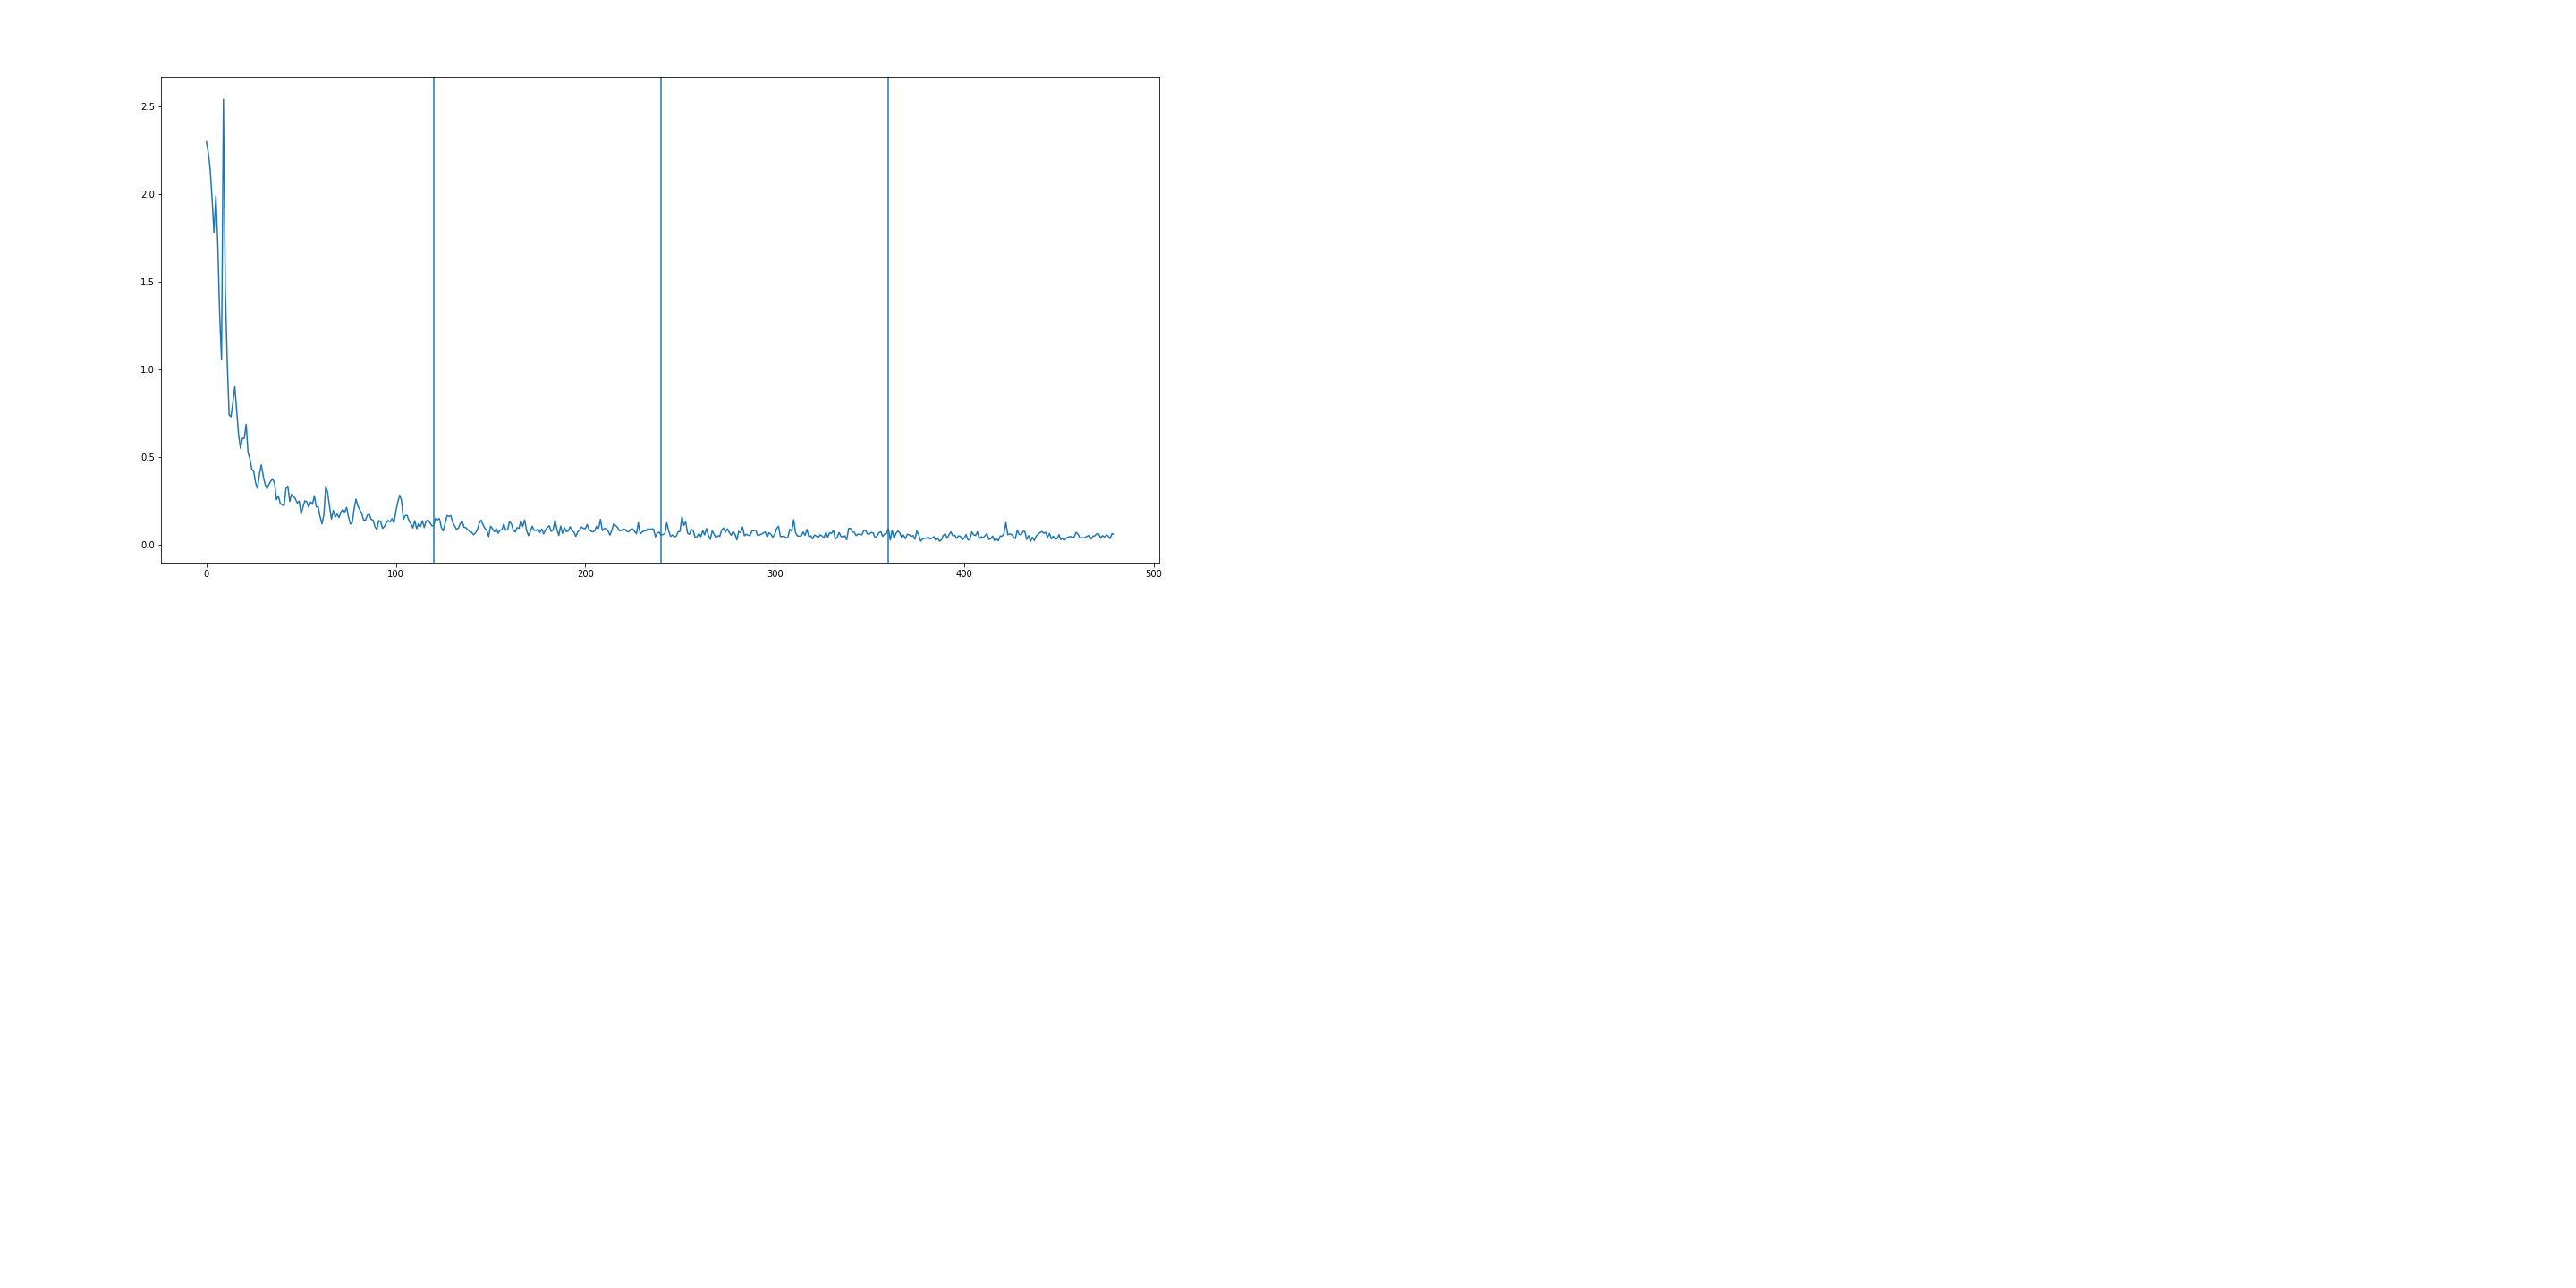

 Epoch: 3, Current loss: 0.0598935522139error mean: 0.0521207046764


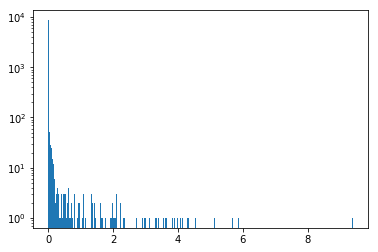

In [36]:
network = myConvNet_2()
batch_size = 10
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adadelta(network.parameters()) 

run_conv_test (network,batch_size,loss_fn,optimizer)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: